<a href="https://colab.research.google.com/github/OscarEngelbrektson/QuantitativeTrading/blob/main/Lesson%209-NLP%20and%20Alternative%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For this preclass work, you will be working with financial data enlisted on the SEC website. Collecting unstructured data and organizing the data into something useful is certainly the most important step for a successful final strategy.

As you follow the code, finish the unfinished cells. 

## Some dependency files and stuff

In [ ]:
!pip -q install wget yfinance

In [ ]:
import wget
wget.download('https://gist.githubusercontent.com/neila/0184545e7a643ff7c506673b15ac3c2b/raw/3efd37ccb3b04513587b1de06494ea6f17aecaad/project_helper.py', out="project_helper.py")
wget.download('http://m.uploadedit.com/busd/1615263226166.txt', out="requirements.txt")
wget.download('https://drive.google.com/uc?export=download&id=12ECPJMxV2wSalXG8ykMmkpa1fq_ur0Rf', out='loughran_mcdonald_master_dic.csv')

'loughran_mcdonald_master_dic (4).csv'

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt
#ignore all the errors we gucci

Processing /root/.cache/pip/wheels/77/1e/9a/223b4c94d7f564f25d94b48ca5b9c53e3034016ece3fd8c8c1/alphalens-0.3.2-cp37-none-any.whl
Processing /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483/nltk-3.4.5-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bf/2d/005e45738ab07a26e621c9c12dc97381f372e06678adf7dc3356a69b5960/numpy-1.13.3.zip
  Using cached https://files.pythonhosted.org/packages/f1/ca/10332a30cb25b627192b4ea272c351bce3ca1091e541245cccbace6051d8/requests-2.20.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/2c/5edf2488897cad4fb8c4ace86369833552615bf264460ae4ef6e1f258982/scikit-learn-0.19.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/3c/341b4fa23cb3abc335207dba057c790f3bb329f6757e1fcd5d347bcf8308/tqdm-4.19.5-py2.py3-none

In [ ]:
!pip install ratelimit==2.2.0

In [ ]:
import urllib
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper

from tqdm import tqdm

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Getting the 10k documents

First, write a function to look up the CIK of a company given their tickers.

In [ ]:
import re, requests

def getCIKs(TICKERS):
    URL = 'http://www.sec.gov/cgi-bin/browse-edgar?CIK={}&Find=Search&owner=exclude&action=getcompany'
    CIK_RE = re.compile(r'.*CIK=(\d{10}).*')    
    cik_dict = {}

    for ticker in TICKERS:
      #Scrape URL
      get_request = requests.get(URL.format(ticker), stream=True);

      #Extract CIK from URL
      results = CIK_RE.findall(get_request.text)

      #Add CIK to dict
      cik_dict[ticker] = results[0]

    return cik_dict



#SHOULD RETURN IN THIS DICTIONARY FORMAT:

assert getCIKs(
    ['AMZN','BMY','CNP','CVX','FL','FRT','HON']
    ) == {
        'AMZN': '0001018724','BMY': '0000014272','CNP': '0001130310',
         'CVX': '0000093410','FL': '0000850209','FRT': '0000034903', 
         'HON': '0000773840'}

In [ ]:
stocks = ["A","AA","AAAU","AACG","AADR","AAL","AAMC","AAME","AAN","AAOI","AAON","AAP","AAPL","AAT","AAU","AAWW","AAXJ","AAXN","AB","ABB","ABBV","ABC","ABCB","ABEO","ABEQ","ABEV","ABG","ABIO","ABM","ABMD","ABR","ABR","ABR","ABR","ABT","ABTX","ABUS","AC","ACA","ACAD","ACAM","ACAMU","ACAMW","ACB","ACBI","ACC","ACCO","ACEL","ACEL","ACER","ACES","ACGL","ACGLO","ACGLP","ACH","ACHC","ACHV","ACIA","ACIO","ACIU","ACIW","ACLS","ACM","ACMR","ACN","ACNB","ACOR","ACP","ACRE","ACRS","ACRX","ACSG","ACSI","ACST","ACT","ACTG","ACTT","ACTTU","ACTTW","ACU","ACV","ACWF","ACWI","ACWV","ACWX","ACY","ADAP","ADBE","ADC","ADES","ADI","ADIL","ADILW","ADM","ADMA","ADME","ADMP","ADMS","ADNT","ADP","ADPT","ADRA","ADRD","ADRE","ADRO","ADRU","ADS","ADSK","ADSW","ADT","ADTN","ADUS","ADVM","ADX","ADXN","ADXS","AE","AEB","AEE","AEF","AEFC","AEG","AEGN","AEHR","AEIS","AEL","AEL","AEM","AEMD","AEO","AEP","AEP","AER","AERI","AES","AESE","AESR","AEY","AEYE","AEZS","AFB","AFC","AFG","AFGB","AFGC","AFGH","AFH","AFI","AFIF","AFIN","AFINP","AFK","AFL","AFLG","AFMC","AFMD","AFSM","AFT","AFTY","AFYA","AG","AGBA","AGBAR","AGBAU","AGBAW","AGCO","AGD","AGE","AGEN","AGFS","AGFSW","AGG","AGGP","AGGY","AGI","AGIO","AGLE","AGM","AGM","AGM","AGM","AGM","AGMH","AGN","AGNC","AGNCM","AGNCN","AGNCO","AGNCP","AGND","AGO","AGO","AGO","AGO","AGQ","AGR","AGRO","AGRX","AGS","AGT","AGTC","AGX","AGYS","AGZ","AGZD","AHC","AHCO","AHH","AHH","AHL","AHL","AHL","AHPI","AHT","AHT","AHT","AHT","AHT","AHT","AI","AI","AI","AIA","AIC","AIEQ","AIF","AIG","AIG","AIG","AIH","AIHS","AIIQ","AIM","AIMC","AIMT","AIN","AINC","AINV","AIO","AIQ","AIR","AIRG","AIRI","AIRR","AIRT","AIRTP","AIRTW","AIT","AIV","AIW","AIZ","AIZP","AJG","AJRD","AJX","AJXA","AKAM","AKBA","AKCA","AKER","AKG","AKO","AKO","AKR","AKRO","AKRX","AKS","AKTS","AKTX","AL","AL","ALAC","ALACR","ALACU","ALACW","ALB","ALBO","ALC","ALCO","ALDX","ALE","ALEC","ALEX","ALFA","ALG","ALGN","ALGR","ALGRR","ALGRU","ALGRW","ALGT","ALIM","ALJJ","ALK","ALKS","ALL","ALL","ALL","ALL","ALL","ALLE","ALLK","ALLO","ALLT","ALLY","ALLY","ALNA","ALNY","ALO","ALOT","ALP","ALPN","ALRM","ALRN","ALRS","ALSK","ALSN","ALT","ALTM","ALTR","ALTS","ALTY","ALUS","ALUS","ALUS","ALV","ALX","ALXN","ALYA","AM","AMAG","AMAL","AMAT","AMBA","AMBC","AMBC","AMBO","AMC","AMCA","AMCI","AMCIU","AMCIW","AMCR","AMCX","AMD","AME","AMED","AMEH","AMG","AMGN","AMH","AMH","AMH","AMH","AMH","AMH","AMHC","AMHCU","AMHCW","AMJ","AMJL","AMK","AMKR","AMLP","AMN","AMNB","AMOM","AMOT","AMOV","AMP","AMPE","AMPH","AMPY","AMRB","AMRC","AMRH","AMRHW","AMRK","AMRN","AMRS","AMRX","AMS","AMSC","AMSF","AMSWA","AMT","AMTB","AMTBB","AMTD","AMTX","AMU","AMUB","AMWD","AMX","AMZA","AMZN","AN","ANAB","ANAT","ANCN","ANDA","ANDAR","ANDAU","ANDAW","ANDE","ANET","ANF","ANGI","ANGL","ANGO","ANH","ANH","ANH","ANH","ANIK","ANIP","ANIX","ANPC","ANSS","ANTE","ANTM","ANVS","ANY","AOA","AOBC","AOD","AOIL","AOK","AOM","AON","AOR","AOS","AOSL","AP","APA","APAM","APD","APDN","APEI","APEN","APEX","APH","APHA","APLE","APLS","APLT","APM","APO","APO","APO","APOG","APOP","APOPW","APPF","APPN","APPS","APRE","APRN","APT","APTO","APTS","APTV","APTX","APVO","APWC","APXT","APXTU","APXTW","APY","APYX","AQB","AQMS","AQN","AQNA","AQNB","AQST","AQUA","AR","ARA","ARAV","ARAY","ARC","ARCB","ARCC","ARCE","ARCH","ARCM","ARCO","ARCT","ARD","ARDC","ARDS","ARDX","ARE","AREC","ARES","ARES","ARGD","ARGO","ARGT","ARGX","ARI","ARKF","ARKG","ARKK","ARKQ","ARKR","ARKW","ARL","ARLO","ARLP","ARMK","ARMP","ARMR","ARNA","ARNC","ARNC","AROC","AROW","ARPO","ARQT","ARR","ARR","ARR","ARTL","ARTLW","ARTNA","ARTW","ARVN","ARW","ARWR","ARYA","ARYAU","ARYAW","ASA","ASB","ASB","ASB","ASB","ASC","ASEA","ASET","ASFI","ASG","ASGN","ASH","ASHR","ASHS","ASHX","ASIX","ASLN","ASM","ASMB","ASML","ASNA","ASND","ASPN","ASPS","ASPU","ASR","ASRT","ASRV","ASRVP","ASTC","ASTE","ASUR","ASX","ASYS","AT","ATAX","ATEC","ATEN","ATEST","ATEST","ATEST","ATEST","ATEX","ATGE","ATH","ATH","ATH","ATHE","ATHM","ATHX","ATI","ATIF","ATKR","ATLC","ATLO","ATMP","ATNI","ATNM","ATNX","ATO","ATOM","ATOS","ATR","ATRA","ATRC","ATRI","ATRO","ATRS","ATSG","ATTO","ATUS","ATV","ATVI","ATXI","AU","AUB","AUBN","AUDC","AUG","AUMN","AUPH","AUSF","AUTL","AUTO","AUY","AVA","AVAL","AVAV","AVB","AVCO","AVD","AVDE","AVDL","AVDV","AVEM","AVEO","AVGO","AVGOP","AVGR","AVH","AVID","AVK","AVLR","AVNS","AVNW","AVRO","AVT","AVTR","AVTR","AVUS","AVUV","AVX","AVXL","AVY","AVYA","AWF","AWI","AWK","AWP","AWR","AWRE","AWTM","AWX","AX","AXAS","AXDX","AXE","AXGN","AXGT","AXJL","AXL","AXLA","AXNX","AXO","AXP","AXR","AXS","AXS","AXSM","AXTA","AXTI","AXU","AY","AYI","AYR","AYTU","AYX","AZN","AZO","AZPN","AZRE","AZRX","AZUL","AZZ","B","BA","BAB","BABA","BAC","BAC","BAC","BAC","BAC","BAC","BAC","BAC","BAC","BAF","BAH","BAK","BAL","BAM","BANC","BANC","BANC","BAND","BANF","BANFP","BANR","BANX","BAP","BAPR","BAR","BASI","BATRA","BATRK","BATT","BAUG","BAX","BB","BBAR","BBAX","BBBY","BBC","BBCA","BBCP","BBD","BBDC","BBDO","BBEU","BBF","BBGI","BBH","BBI","BBIN","BBIO","BBJP","BBK","BBL","BBN","BBP","BBQ","BBRE","BBSA","BBSI","BBU","BBUS","BBVA","BBW","BBX","BBY","BC","BC","BC","BC","BCBP","BCC","BCD","BCDA","BCDAW","BCE","BCEI","BCEL","BCH","BCI","BCLI","BCM","BCML","BCO","BCOM","BCOR","BCOV","BCOW","BCPC","BCRH","BCRX","BCS","BCSF","BCTF","BCV","BCV","BCX","BCYC","BDC","BDCL","BDCS","BDCY","BDCZ","BDEC","BDGE","BDJ","BDL","BDN","BDR","BDRY","BDSI","BDTX","BDX","BDXA","BE","BEAM","BEAT","BECN","BEDU","BELFA","BELFB","BEN","BEP","BERY","BEST","BF","BF","BFAM","BFC","BFEB","BFIN","BFIT","BFK","BFO","BFOR","BFRA","BFS","BFS","BFS","BFST","BFY","BFZ","BG","BGB","BGCP","BGFV","BGG","BGH","BGI","BGIO","BGNE","BGR","BGRN","BGS","BGSF","BGT","BGX","BGY","BH","BH","BHAT","BHB","BHC","BHE","BHF","BHFAL","BHFAP","BHK","BHLB","BHP","BHR","BHR","BHR","BHTG","BHV","BHVN","BIB","BIBL","BICK","BIDU","BIF","BIG","BIIB","BIL","BILI","BILL","BIMI","BIO","BIO","BIOC","BIOL","BIOX","BIOX","BIP","BIS","BIT","BITA","BIV","BIZD","BJ","BJAN","BJK","BJRI","BJUL","BJUN","BK","BK","BKCC","BKD","BKE","BKEP","BKEPP","BKF","BKH","BKI","BKK","BKLN","BKN","BKNG","BKR","BKSC","BKT","BKTI","BKU","BKYI","BL","BLBD","BLCM","BLCN","BLD","BLDP","BLDR","BLE","BLES","BLFS","BLHY","BLIN","BLK","BLKB","BLL","BLMN","BLNK","BLNKW","BLOK","BLPH","BLRX","BLU","BLUE","BLV","BLW","BLX","BMA","BMCH","BME","BMEZ","BMI","BML","BML","BML","BML","BMLP","BMO","BMRA","BMRC","BMRN","BMTC","BMY","BMY","BND","BNDC","BNDW","BNDX","BNED","BNFT","BNGO","BNGOW","BNKD","BNKO","BNKU","BNKZ","BNO","BNOV","BNS","BNSO","BNTC","BNTCW","BNTX","BNY","BOCH","BOCT","BOE","BOH","BOIL","BOKF","BOKFL","BOMN","BOND","BOOM","BOOT","BORR","BOSC","BOSS","BOTJ","BOTZ","BOUT","BOX","BOXL","BP","BPFH","BPMC","BPMP","BPMX","BPOP","BPOPM","BPOPN","BPR","BPRAP","BPRN","BPT","BPTH","BPY","BPYPO","BPYPP","BQH","BR","BRBR","BRBS","BRC","BREW","BRF","BRFS","BRG","BRG","BRG","BRG","BRID","BRK","BRK","BRKL","BRKR","BRKS","BRMK","BRMK","BRN","BRO","BROG","BROGW","BRP","BRPA","BRPAR","BRPAU","BRPAW","BRPM","BRPM","BRPM","BRQS","BRT","BRX","BRY","BRZU","BSA","BSAC","BSAE","BSBE","BSBK","BSBR","BSCE","BSCK","BSCL","BSCM","BSCN","BSCO","BSCP","BSCQ","BSCR","BSCS","BSCT","BSD","BSDE","BSE","BSEP","BSET","BSGM","BSIG","BSJK","BSJL","BSJM","BSJN","BSJO","BSJP","BSJQ","BSJR","BSL","BSM","BSML","BSMM","BSMN","BSMO","BSMP","BSMQ","BSMR","BSMS","BSMT","BSMX","BSQR","BSRR","BST","BSTC","BSTZ","BSV","BSVN","BSX","BTA","BTAI","BTAL","BTE","BTEC","BTG","BTI","BTN","BTO","BTT","BTU","BTYS","BTZ","BUD","BUG","BUI","BUL","BURG","BURL","BUSE","BUY","BUYN","BV","BVAL","BVN","BVSN","BVXV","BVXVW","BW","BWA","BWAY","BWB","BWEN","BWFG","BWG","BWL","BWMC","BWMCU","BWMCW","BWX","BWXT","BWZ","BX","BXC","BXG","BXMT","BXMX","BXP","BXP","BXRX","BXS","BXS","BY","BYD","BYFC","BYLD","BYM","BYND","BYSI","BZH","BZM","BZQ","BZUN","C","C","C","C","C","CAAP","CAAS","CABA","CABO","CAC","CACC","CACG","CACI","CADE","CAE","CAF","CAG","CAH","CAI","CAI","CAI","CAJ","CAKE","CAL","CALA","CALF","CALM","CALX","CAMP","CAMT","CAN","CANE","CANF","CANG","CAPE","CAPL","CAPR","CAR","CARA","CARE","CARG","CARO","CARS","CARV","CARZ","CASA","CASH","CASI","CASS","CASY","CAT","CATB","CATC","CATH","CATM","CATO","CATS","CATY","CB","CBAN","CBAT","CBAY","CBB","CBB","CBD","CBFV","CBH","CBIO","CBL","CBL","CBL","CBLI","CBMB","CBMG","CBNK","CBO","CBOE","CBON","CBPO","CBRE","CBRL","CBSH","CBSHP","CBT","CBTX","CBU","CBX","CBZ","CC","CCAC","CCAP","CCB","CCBG","CCC","CCC","CCCL","CCD","CCEP","CCF","CCH","CCH","CCH","CCI","CCI","CCJ","CCK","CCL","CCLP","CCM","CCMP","CCNE","CCO","CCOI","CCOR","CCR","CCRC","CCRN","CCS","CCU","CCX","CCX","CCX","CCXI","CCZ","CDAY","CDC","CDE","CDEV","CDK","CDL","CDLX","CDMO","CDMOP","CDNA","CDNS","CDOR","CDR","CDR","CDR","CDTX","CDW","CDXC","CDXS","CDZI","CE","CEA","CECE","CEE","CEF","CEFL","CEFS","CEFZ","CEI","CEIX","CEL","CELC","CELG","CELH","CELP","CEM","CEMB","CEMI","CEN","CENT","CENTA","CENX","CEO","CEPU","CEQP","CEQP","CERC","CERN","CERS","CET","CETV","CETX","CETXP","CETXW","CEV","CEVA","CEW","CEY","CEZ","CF","CFA","CFB","CFBI","CFBK","CFFA","CFFAU","CFFAW","CFFI","CFFN","CFG","CFG","CFG","CFMS","CFO","CFR","CFR","CFRX","CFX","CFXA","CG","CGA","CGBD","CGC","CGEN","CGIX","CGNX","CGO","CGW","CHA","CHAD","CHAP","CHAU","CHCI","CHCO","CHCT","CHD","CHDN","CHE","CHEF","CHEK","CHEKW","CHEKZ","CHEP","CHFS","CHGG","CHGX","CHH","CHI","CHIC","CHIE","CHIH","CHII","CHIK","CHIL","CHIM","CHIQ","CHIR","CHIS","CHIU","CHIX","CHK","CHK","CHKP","CHKR","CHL","CHMA","CHMG","CHMI","CHMI","CHMI","CHN","CHNA","CHNG","CHNGU","CHNR","CHPM","CHPMU","CHPMW","CHRA","CHRS","CHRW","CHS","CHSCL","CHSCM","CHSCN","CHSCO","CHSCP","CHT","CHTR","CHU","CHUY","CHW","CHWY","CHY","CI","CIA","CIB","CIBR","CID","CIDM","CIEN","CIF","CIFS","CIG","CIG","CIGI","CIH","CII","CIIC","CIICU","CIICW","CIK","CIL","CIM","CIM","CIM","CIM","CIM","CINF","CINR","CIO","CIO","CIR","CIT","CIT","CIVB","CIX","CIZ","CIZN","CJJD","CKH","CKPT","CKX","CL","CLAR","CLB","CLBK","CLBS","CLCT","CLDB","CLDR","CLDT","CLDX","CLF","CLFD","CLGN","CLGX","CLH","CLI","CLIR","CLIX","CLLS","CLM","CLMT","CLNC","CLNE","CLNY","CLNY","CLNY","CLNY","CLNY","CLOU","CLPR","CLPS","CLPT","CLR","CLRB","CLRBZ","CLRG","CLRO","CLS","CLSD","CLSK","CLSN","CLTL","CLUB","CLVS","CLW","CLWT","CLX","CLXT","CM","CMA","CMBM","CMBS","CMC","CMCL","CMCM","CMCO","CMCSA","CMCT","CMCTP","CMD","CMDY","CME","CMF","CMFNL","CMG","CMI","CMLS","CMO","CMO","CMP","CMPR","CMRE","CMRE","CMRE","CMRE","CMRE","CMRX","CMS","CMS","CMSA","CMSC","CMSD","CMT","CMTL","CMU","CN","CNA","CNAT","CNBKA","CNBS","CNC","CNCE","CNCR","CNDT","CNET","CNF","CNFR","CNFRL","CNHI","CNI","CNK","CNMD","CNNB","CNNE","CNO","CNOB","CNP","CNP","CNQ","CNR","CNRG","CNS","CNSL","CNSP","CNST","CNTG","CNTY","CNX","CNXM","CNXN","CNXT","CNY","CNYA","CO","COCP","CODA","CODI","CODI","CODI","CODI","CODX","COE","COF","COF","COF","COF","COF","COF","COF","COFS","COG","COHN","COHR","COHU","COKE","COLB","COLD","COLL","COLM","COM","COMB","COMM","COMT","CONE","CONN","COO","COOP","COP","COPX","COR","CORE","CORN","CORP","CORR","CORR","CORT","CORV","COST","COT","COTY","COUP","COW","COWN","COWNL","COWNZ","COWZ","CP","CPA","CPAA","CPAAU","CPAAW","CPAC","CPAH","CPB","CPE","CPER","CPF","CPG","CPHC","CPHI","CPI","CPIX","CPK","CPLG","CPLP","CPRI","CPRT","CPRX","CPS","CPSH","CPSI","CPSS","CPST","CPT","CPTA","CPTAG","CPTAL","CPZ","CQP","CQQQ","CR","CRAI","CRAK","CRBN","CRBP","CRC","CRD","CRD","CREE","CREG","CRESY","CREX","CREXW","CRF","CRH","CRHM","CRI","CRIS","CRK","CRL","CRM","CRMD","CRMT","CRNC","CRNT","CRNX","CROC","CRON","CROP","CROX","CRS","CRSA","CRSAU","CRSAW","CRSP","CRT","CRTO","CRTX","CRUS","CRVL","CRVS","CRWD","CRWS","CRY","CS","CSA","CSB","CSBR","CSCO","CSD","CSF","CSFL","CSGP","CSGS","CSII","CSIQ","CSL","CSLT","CSM","CSML","CSOD","CSPI","CSPR","CSQ","CSS","CSSE","CSSEP","CSTE","CSTL","CSTM","CSTR","CSU","CSV","CSWC","CSWCL","CSWI","CSX","CTA","CTA","CTAA","CTAC","CTACU","CTACW","CTAS","CTB","CTBB","CTBI","CTDD","CTEK","CTEST","CTEST","CTEST","CTEST","CTEST","CTEST","CTEST","CTG","CTHR","CTIB","CTIC","CTK","CTL","CTLT","CTMX","CTO","CTR","CTRA","CTRC","CTRE","CTRM","CTRN","CTS","CTSH","CTSO","CTST","CTT","CTV","CTVA","CTXR","CTXRW","CTXS","CTY","CTZ","CUB","CUBA","CUBB","CUBE","CUBI","CUBI","CUBI","CUBI","CUBI","CUE","CUI","CUK","CULP","CUO","CURE","CURO","CUT","CUTR","CUZ","CVA","CVBF","CVCO","CVCY","CVE","CVEO","CVET","CVGI","CVGW","CVI","CVIA","CVLT","CVLY","CVM","CVNA","CVR","CVS","CVTI","CVU","CVV","CVX","CVY","CW","CWB","CWBC","CWBR","CWCO","CWEB","CWEN","CWEN","CWH","CWI","CWK","CWS","CWST","CWT","CX","CXDC","CXE","CXH","CXO","CXP","CXSE","CXW","CY","CYAD","CYAN","CYB","CYBE","CYBR","CYCC","CYCCP","CYCN","CYD","CYH","CYOU","CYRN","CYRX","CYRXW","CYTK","CZA","CZNC","CZR","CZWI","CZZ","D","DAC","DAIO","DAKT","DAL","DALI","DALT","DAN","DAO","DAR","DARE","DAUD","DAUG","DAVA","DAX","DB","DBA","DBAW","DBB","DBC","DBD","DBE","DBEF","DBEH","DBEM","DBEU","DBEZ","DBGR","DBI","DBJP","DBL","DBLV","DBMF","DBO","DBP","DBS","DBV","DBVT","DBX","DCAR","DCF","DCHF","DCI","DCIX","DCO","DCOM","DCP","DCP","DCP","DCPH","DCUE","DD","DDD","DDF","DDG","DDIV","DDLS","DDM","DDMX","DDMXU","DDMXW","DDOG","DDS","DDT","DDWM","DE","DEA","DEAC","DEACU","DEACW","DECK","DEEF","DEF","DEFA","DEI","DELL","DEM","DENN","DEO","DERM","DES","DESP","DEUR","DEUS","DEW","DEX","DFE","DFEN","DFFN","DFIN","DFJ","DFND","DFNL","DFNSU","DFP","DFS","DFVL","DFVS","DG","DGAZ","DGBP","DGICA","DGICB","DGII","DGL","DGLD","DGLY","DGP","DGRE","DGRO","DGRS","DGRW","DGS","DGT","DGX","DGZ","DHC","DHCNI","DHCNL","DHDG","DHF","DHI","DHIL","DHR","DHR","DHS","DHT","DHX","DHY","DIA","DIAL","DIAX","DIET","DIG","DIM","DIN","DINT","DIOD","DIS","DISCA","DISCB","DISCK","DISH","DIT","DIV","DIVA","DIVB","DIVC","DIVO","DIVY","DJCB","DJCI","DJCO","DJD","DJP","DJPY","DK","DKL","DKS","DL","DLA","DLB","DLBR","DLBS","DLHC","DLN","DLNG","DLNG","DLNG","DLPH","DLPN","DLPNW","DLR","DLR","DLR","DLR","DLR","DLR","DLR","DLS","DLTH","DLTR","DLX","DMAC","DMB","DMDV","DMF","DMLP","DMO","DMPI","DMRC","DMRE","DMRI","DMRL","DMRM","DMRS","DMTK","DNI","DNJR","DNK","DNKN","DNL","DNLI","DNN","DNOV","DNOW","DNP","DNR","DO","DOC","DOCU","DOG","DOGS","DOGZ","DOL","DOMO","DON","DOO","DOOO","DOOR","DORM","DOV","DOW","DOX","DOYU","DPG","DPHC","DPHCU","DPHCW","DPK","DPST","DPW","DPZ","DQ","DRAD","DRADP","DRD","DRE","DRH","DRI","DRIO","DRIOW","DRIP","DRIV","DRN","DRNA","DRQ","DRR","DRRX","DRSK","DRTT","DRUA","DRV","DRW","DS","DS","DS","DS","DSE","DSGX","DSI","DSKE","DSKEW","DSL","DSLV","DSM","DSPG","DSS","DSSI","DSTL","DSU","DSWL","DSX","DSX","DT","DTD","DTE","DTEA","DTEC","DTF","DTH","DTIL","DTJ","DTLA","DTN","DTO","DTP","DTQ","DTSS","DTUL","DTUS","DTW","DTY","DTYL","DTYS","DUC","DUG","DUK","DUK","DUKB","DUKH","DUO","DURA","DUSA","DUSL","DUST","DVA","DVAX","DVD","DVEM","DVHL","DVLU","DVN","DVOL","DVOP","DVP","DVY","DVYA","DVYE","DVYL","DWAQ","DWAS","DWAT","DWAW","DWCR","DWEQ","DWFI","DWIN","DWLD","DWM","DWMC","DWMF","DWPP","DWSH","DWSN","DWT","DWTR","DWUS","DWX","DX","DX","DX","DXB","DXC","DXCM","DXD","DXF","DXGE","DXJ","DXJS","DXLG","DXPE","DXR","DXYN","DY","DYAI","DYLS","DYNF","DYNT","DZK","DZSI","DZZ","E","EA","EAB","EAD","EAE","EAF","EAGG","EAI","EARN","EARS","EASG","EASI","EAST","EAT","EB","EBAY","EBAYL","EBF","EBIX","EBIZ","EBMT","EBND","EBR","EBR","EBS","EBSB","EBTC","EC","ECC","ECCB","ECCX","ECCY","ECF","ECF","ECH","ECHO","ECL","ECLN","ECNS","ECOL","ECOLW","ECOM","ECON","ECOR","ECOW","ECPG","ECT","ED","EDAP","EDC","EDD","EDEN","EDF","EDI","EDIT","EDIV","EDN","EDNT","EDOG","EDOW","EDRY","EDSA","EDTX","EDTXU","EDTXW","EDU","EDUC","EDV","EDZ","EE","EEA","EEB","EEFT","EEH","EELV","EEM","EEMA","EEMD","EEMO","EEMS","EEMV","EEMX","EES","EET","EEV","EEX","EFA","EFAD","EFAS","EFAV","EFAX","EFC","EFC","EFF","EFG","EFL","EFNL","EFO","EFOI","EFR","EFSC","EFT","EFU","EFV","EFX","EFZ","EGAN","EGBN","EGF","EGHT","EGIF","EGLE","EGO","EGOV","EGP","EGPT","EGRX","EGY","EH","EHC","EHI","EHT","EHTH","EIC","EIDO","EIDX","EIG","EIGI","EIGR","EIM","EINC","EIRL","EIS","EIX","EJAN","EJUL","EKAR","EKSO","EL","ELA","ELAN","ELAT","ELC","ELD","ELF","ELGX","ELJ","ELLO","ELMD","ELOX","ELP","ELS","ELSE","ELTK","ELU","ELVT","ELY","EMAG","EMAN","EMB","EMBH","EMCB","EMCF","EMCG","EMD","EMDV","EME","EMF","EMFM","EMGF","EMHY","EMIF","EMIH","EMKR","EML","EMLC","EMLP","EMMF","EMMS","EMN","EMNT","EMO","EMP","EMQQ","EMR","EMSG","EMSH","EMTL","EMTY","EMX","EMXC","ENB","ENBA","ENBL","ENDP","ENFR","ENG","ENIA","ENIC","ENJ","ENLC","ENLV","ENO","ENOB","ENOR","ENPH","ENR","ENR","ENS","ENSG","ENSV","ENT","ENTA","ENTG","ENTR","ENTX","ENTXW","ENV","ENVA","ENX","ENZ","ENZL","EOD","EOG","EOI","EOLS","EOS","EOT","EP","EPAC","EPAM","EPAY","EPC","EPD","EPHE","EPI","EPIX","EPM","EPOL","EPP","EPR","EPR","EPR","EPR","EPRF","EPRT","EPS","EPSN","EPU","EPV","EPZM","EQ","EQAL","EQBK","EQC","EQC","EQH","EQH","EQIX","EQL","EQM","EQNR","EQR","EQRR","EQS","EQT","EQWL","EQX","ERA","ERC","ERF","ERH","ERI","ERIC","ERIE","ERII","ERJ","ERM","EROS","ERSX","ERUS","ERX","ERY","ERYP","ES","ESBA","ESBK","ESCA","ESE","ESEA","ESG","ESGD","ESGE","ESGF","ESGG","ESGL","ESGN","ESGR","ESGRO","ESGRP","ESGS","ESGU","ESGV","ESGW","ESI","ESLT","ESML","ESNG","ESNT","ESP","ESPO","ESPR","ESQ","ESRT","ESS","ESSA","ESTA","ESTC","ESTE","ESXB","ET","ETB","ETFC","ETG","ETH","ETHO","ETI","ETJ","ETM","ETN","ETNB","ETO","ETON","ETP","ETP","ETP","ETR","ETRN","ETSY","ETTX","ETV","ETW","ETX","ETY","EUDG","EUDV","EUFL","EUFN","EUFX","EUM","EUMF","EUMV","EUO","EURL","EURN","EURZ","EUSA","EUSC","EV","EVA","EVBG","EVBN","EVC","EVER","EVF","EVFM","EVG","EVGBC","EVGN","EVH","EVI","EVIX","EVK","EVLMC","EVLO","EVM","EVN","EVOK","EVOL","EVOP","EVR","EVRG","EVRI","EVSI","EVSIW","EVSTC","EVT","EVTC","EVV","EVX","EVY","EW","EWA","EWBC","EWC","EWCO","EWD","EWEM","EWG","EWGS","EWH","EWI","EWJ","EWJE","EWJV","EWK","EWL","EWM","EWMC","EWN","EWO","EWP","EWQ","EWRE","EWS","EWSC","EWT","EWU","EWUS","EWV","EWW","EWX","EWY","EWZ","EWZS","EXAS","EXC","EXD","EXEL","EXFO","EXG","EXI","EXIV","EXK","EXLS","EXP","EXPC","EXPCU","EXPCW","EXPD","EXPE","EXPI","EXPO","EXPR","EXR","EXT","EXTN","EXTR","EYE","EYEG","EYEGW","EYEN","EYES","EYESW","EYLD","EYPT","EZA","EZJ","EZM","EZPW","EZT","EZU","F","F","F","FAAR","FAB","FAD","FAF","FALN","FAM","FAMI","FAN","FANG","FANH","FARM","FARO","FAS","FAST","FAT","FATE","FAUG","FAUS","FAX","FAZ","FB","FBC","FBGX","FBHS","FBIO","FBIOP","FBIZ","FBK","FBM","FBMS","FBNC","FBND","FBP","FBSS","FBT","FBZ","FC","FCA","FCAL","FCAN","FCAP","FCAU","FCBC","FCBP","FCCO","FCCY","FCEF","FCEL","FCF","FCFS","FCG","FCN","FCNCA","FCO","FCOM","FCOR","FCPI","FCPT","FCT","FCTR","FCVT","FCX","FDBC","FDD","FDEF","FDEM","FDEU","FDEV","FDHY","FDIS","FDIV","FDL","FDLO","FDM","FDMO","FDN","FDNI","FDP","FDRR","FDS","FDT","FDTS","FDUS","FDUSG","FDUSL","FDUSZ","FDVV","FDX","FE","FEDU","FEI","FEIM","FELE","FEM","FEMB","FEMS","FEN","FENC","FENG","FENY","FEO","FEP","FET","FEUL","FEUZ","FEX","FEYE","FEZ","FF","FFA","FFBC","FFBW","FFC","FFEU","FFG","FFHG","FFHL","FFIC","FFIN","FFIU","FFIV","FFNW","FFR","FFSG","FFTG","FFTI","FFTY","FFWM","FG","FG","FGB","FGBI","FGD","FGEN","FGM","FHB","FHI","FHK","FHLC","FHN","FHN","FI","FIBK","FIBR","FICO","FID","FIDI","FIDU","FIEE","FIF","FIHD","FILL","FINS","FINU","FINV","FINX","FINZ","FIS","FISI","FISK","FISR","FISV","FIT","FITB","FITBI","FITBO","FITBP","FITE","FIV","FIVA","FIVE","FIVG","FIVN","FIW","FIX","FIXD","FIXX","FIYY","FIZZ","FJNK","FJP","FKO","FKU","FL","FLAG","FLAT","FLAU","FLAX","FLBL","FLBR","FLC","FLCA","FLCB","FLCH","FLCO","FLDM","FLDR","FLEE","FLEH","FLEU","FLEX","FLFR","FLGB","FLGE","FLGR","FLGT","FLHK","FLHY","FLIA","FLIC","FLIN","FLIO","FLIR","FLIY","FLJH","FLJP","FLKR","FLL","FLLA","FLLC","FLLCR","FLLCU","FLLCW","FLLV","FLM","FLMB","FLMI","FLMN","FLMNW","FLMX","FLN","FLNG","FLNT","FLO","FLOT","FLOW","FLQD","FLQE","FLQG","FLQH","FLQL","FLQM","FLQS","FLR","FLRN","FLRT","FLRU","FLS","FLSA","FLSP","FLSW","FLT","FLTB","FLTR","FLTW","FLWS","FLXN","FLXS","FLY","FLYT","FLZA","FM","FMAO","FMAT","FMB","FMBH","FMBI","FMC","FMCI","FMCIU","FMCIW","FMF","FMHI","FMK","FMN","FMNB","FMO","FMS","FMX","FMY","FN","FNB","FNB","FNCB","FNCL","FND","FNDA","FNDB","FNDC","FNDE","FNDF","FNDX","FNF","FNGD","FNGO","FNGS","FNGU","FNGZ","FNHC","FNI","FNJN","FNK","FNKO","FNLC","FNOV","FNV","FNWB","FNX","FNY","FOCS","FOE","FOF","FOLD","FOMX","FONR","FOR","FORD","FORK","FORM","FORR","FORTY","FOSL","FOVL","FOX","FOXA","FOXF","FPA","FPAC","FPAC","FPAC","FPAY","FPAYW","FPE","FPEI","FPF","FPH","FPI","FPI","FPL","FPRX","FPX","FPXE","FPXI","FQAL","FR","FRA","FRAF","FRAK","FRAN","FRBA","FRBK","FRC","FRC","FRC","FRC","FRC","FRC","FRD","FRDM","FREL","FREQ","FRG","FRGI","FRHC","FRI","FRLG","FRME","FRN","FRO","FRPH","FRPT","FRSX","FRT","FRT","FRTA","FSB","FSBC","FSBW","FSCT","FSD","FSEA","FSFG","FSI","FSK","FSLR","FSLY","FSM","FSMB","FSMD","FSP","FSRV","FSRVU","FSRVW","FSS","FSTA","FSTR","FSV","FSZ","FT","FTA","FTAC","FTACU","FTACW","FTAG","FTAI","FTAI","FTAI","FTC","FTCH","FTCS","FTDR","FTEC","FTEK","FTEO","FTF","FTFT","FTGC","FTHI","FTI","FTK","FTLB","FTLS","FTNT","FTR","FTRI","FTS","FTSD","FTSI","FTSL","FTSM","FTSV","FTV","FTV","FTXD","FTXG","FTXH","FTXL","FTXN","FTXO","FTXR","FUD","FUE","FUL","FULC","FULT","FUMB","FUN","FUNC","FUND","FUSB","FUT","FUTU","FUTY","FUV","FV","FVAL","FVC","FVCB","FVD","FVE","FVL","FVRR","FWDB","FWONA","FWONK","FWP","FWRD","FXA","FXB","FXC","FXCH","FXD","FXE","FXF","FXG","FXH","FXI","FXL","FXN","FXNC","FXO","FXP","FXR","FXS","FXSG","FXU","FXY","FXZ","FYC","FYLD","FYT","FYX","G","GAA","GAB","GAB","GAB","GAB","GAB","GABC","GAIA","GAIN","GAINL","GAINM","GAL","GALT","GAM","GAM","GAMR","GARD","GARS","GASL","GASS","GASX","GATX","GAZ","GBAB","GBCI","GBDC","GBDV","GBF","GBIL","GBL","GBLI","GBLIL","GBLIZ","GBR","GBT","GBUG","GBUY","GBX","GCAP","GCBC","GCC","GCE","GCI","GCO","GCOW","GCP","GCV","GCVRZ","GD","GDAT","GDDY","GDEN","GDI","GDL","GDL","GDMA","GDNA","GDO","GDOT","GDP","GDS","GDV","GDV","GDV","GDV","GDVD","GDX","GDXJ","GE","GEC","GECC","GECCL","GECCM","GECCN","GEF","GEF","GEL","GEM","GEN","GENC","GENE","GENY","GEO","GEOS","GER","GERN","GES","GEVO","GF","GFED","GFF","GFI","GFIN","GFN","GFNCP","GFNSL","GFY","GGAL","GGB","GGG","GGM","GGN","GGN","GGO","GGO","GGT","GGT","GGT","GGZ","GGZ","GH","GHC","GHG","GHII","GHIVU","GHL","GHM","GHSI","GHY","GHYB","GHYG","GIB","GIFI","GIGB","GIGE","GIGM","GII","GIII","GIL","GILD","GILT","GIM","GIS","GIX","GIX","GIX","GIX","GJH","GJO","GJP","GJR","GJS","GJT","GKOS","GL","GL","GLAD","GLADD","GLADL","GLBS","GLBY","GLBZ","GLD","GLDD","GLDI","GLDM","GLEO","GLEO","GLEO","GLG","GLIBA","GLIBP","GLIF","GLL","GLMD","GLNG","GLO","GLOB","GLOG","GLOG","GLOP","GLOP","GLOP","GLOP","GLOW","GLP","GLP","GLPG","GLPI","GLQ","GLRE","GLT","GLTR","GLU","GLU","GLU","GLUU","GLV","GLW","GLYC","GM","GMAB","GMAN","GMDA","GME","GMED","GMF","GMHI","GMHIU","GMHIW","GMLP","GMLPP","GMO","GMOM","GMRE","GMRE","GMS","GMTA","GMZ","GNAF","GNC","GNCA","GNE","GNE","GNFT","GNK","GNL","GNL","GNL","GNLN","GNMA","GNMK","GNOM","GNPX","GNR","GNRC","GNRSU","GNSS","GNT","GNT","GNTX","GNTY","GNUS","GNW","GO","GOAT","GOAU","GOEX","GOF","GOGL","GOGO","GOL","GOLD","GOLF","GOOD","GOODM","GOODN","GOOG","GOOGL","GOOS","GORO","GOSS","GOVT","GPAQ","GPAQU","GPAQW","GPC","GPI","GPJA","GPK","GPL","GPM","GPMT","GPN","GPOR","GPP","GPRE","GPRK","GPRO","GPS","GPX","GQRE","GRA","GRAF","GRAF","GRAF","GRAM","GRBK","GRC","GREK","GRES","GRF","GRFS","GRID","GRIF","GRIN","GRMN","GRN","GRNB","GRNQ","GRNV","GRNVR","GRNVU","GRNVW","GROW","GRP","GRPN","GRTS","GRTX","GRU","GRUB","GRVY","GRWG","GRX","GRX","GRX","GS","GS","GS","GS","GS","GS","GS","GSAT","GSB","GSBC","GSBD","GSC","GSEU","GSEW","GSG","GSH","GSHD","GSIE","GSIT","GSJY","GSK","GSKY","GSL","GSL","GSLC","GSLD","GSM","GSP","GSS","GSSC","GSST","GSUM","GSV","GSX","GSY","GT","GTE","GTEC","GTES","GTHX","GTIM","GTIP","GTLS","GTN","GTN","GTO","GTS","GTT","GTX","GTY","GTYH","GUDB","GULF","GUNR","GURE","GURU","GUSH","GUT","GUT","GUT","GV","GVA","GVAL","GVI","GVIP","GVP","GWB","GWGH","GWPH","GWRE","GWRS","GWW","GWX","GXC","GXF","GXG","GXGX","GXGXU","GXGXW","GXTG","GYC","GYLD","GYRO","H","HA","HABT","HACK","HAE","HAFC","HAIL","HAIN","HAL","HALL","HALO","HAO","HAP","HAPP","HARP","HAS","HASI","HAUD","HAUZ","HAWX","HAYN","HBAN","HBANN","HBANO","HBB","HBCP","HBI","HBIO","HBM","HBMD","HBNC","HBP","HBT","HCA","HCAC","HCACU","HCACW","HCAP","HCAPZ","HCAT","HCC","HCCH","HCCHR","HCCHU","HCCHW","HCCI","HCCO","HCCOU","HCCOW","HCFT","HCHC","HCI","HCKT","HCM","HCR","HCSG","HCXY","HCXZ","HD","HDAW","HDB","HDEF","HDG","HDGE","HDLB","HDLV","HDMV","HDS","HDSN","HDV","HE","HEAR","HEBT","HECO","HEDJ","HEEM","HEES","HEFA","HEI","HEI","HELE","HEP","HEPA","HEQ","HERD","HERO","HES","HESM","HEWC","HEWG","HEWI","HEWJ","HEWL","HEWP","HEWU","HEWW","HEWY","HEXO","HEZU","HFBL","HFC","HFFG","HFRO","HFRO","HFWA","HFXE","HFXI","HFXJ","HGH","HGLB","HGSH","HGV","HHC","HHHH","HHHHR","HHHHU","HHHHW","HHR","HHS","HHT","HI","HIBB","HIBL","HIBS","HIE","HIFS","HIG","HIG","HIHO","HII","HIIQ","HIL","HIMX","HIO","HIPS","HIW","HIX","HJLI","HJLIW","HJPX","HJV","HKIB","HL","HL","HLAL","HLF","HLG","HLI","HLIO","HLIT","HLM","HLNE","HLT","HLX","HMC","HMG","HMHC","HMI","HMLP","HMLP","HMN","HMNF","HMOP","HMST","HMSY","HMTV","HMY","HNDL","HNGR","HNI","HNNA","HNP","HNRG","HNW","HOFT","HOG","HOLD","HOLI","HOLX","HOMB","HOME","HOML","HOMZ","HON","HONE","HOOK","HOPE","HOTH","HOV","HOVNP","HP","HPE","HPF","HPI","HPP","HPQ","HPR","HPS","HQH","HQI","HQL","HQY","HR","HRB","HRC","HRI","HRL","HROW","HRTG","HRTX","HRZN","HSBC","HSBC","HSC","HSCZ","HSDT","HSIC","HSII","HSKA","HSON","HSPX","HSRT","HST","HSTM","HSY","HT","HT","HT","HT","HTA","HTAB","HTBI","HTBK","HTBX","HTD","HTEC","HTFA","HTGC","HTGM","HTH","HTHT","HTIA","HTLD","HTLF","HTRB","HTUS","HTY","HTZ","HUBB","HUBG","HUBS","HUD","HUGE","HUIZ","HUM","HUN","HURC","HURN","HUSA","HUSE","HUSV","HUYA","HVBC","HVT","HVT","HWBK","HWC","HWCC","HWCPL","HWKN","HX","HXL","HY","HYAC","HYACU","HYACW","HYB","HYD","HYDB","HYDW","HYEM","HYG","HYGH","HYGV","HYHG","HYI","HYIH","HYLB","HYLD","HYLS","HYLV","HYMB","HYND","HYRE","HYS","HYT","HYTR","HYUP","HYXE","HYXU","HYZD","HZN","HZNP","HZO","I","IAA","IAC","IAE","IAF","IAG","IAGG","IAI","IAK","IART","IAT","IAU","IAUF","IBA","IBB","IBCD","IBCE","IBCP","IBD","IBDC","IBDD","IBDL","IBDM","IBDN","IBDO","IBDP","IBDQ","IBDR","IBDS","IBDT","IBDU","IBHA","IBHB","IBHC","IBHD","IBHE","IBIO","IBKC","IBKCN","IBKCO","IBKCP","IBKR","IBM","IBMI","IBMJ","IBMK","IBML","IBMM","IBMN","IBMO","IBMP","IBMQ","IBN","IBND","IBO","IBOC","IBP","IBTX","IBUY","ICAD","ICBK","ICCC","ICCH","ICD","ICE","ICF","ICFI","ICHR","ICL","ICLK","ICLN","ICLR","ICMB","ICOL","ICON","ICOW","ICPT","ICSH","ICUI","ICVT","IDA","IDCC","IDE","IDEV","IDEX","IDHD","IDHQ","IDIV","IDLB","IDLV","IDMO","IDN","IDNA","IDOG","IDRA","IDRV","IDT","IDU","IDV","IDX","IDXG","IDXX","IDY","IDYA","IEA","IEAWW","IEC","IECS","IEDI","IEF","IEFA","IEFN","IEHS","IEI","IEIH","IEMD","IEME","IEMG","IEMV","IEO","IEP","IESC","IETC","IEUR","IEUS","IEV","IEX","IEZ","IFEU","IFF","IFFT","IFGL","IFLY","IFMK","IFN","IFRA","IFRX","IFS","IFV","IG","IGA","IGBH","IGC","IGD","IGE","IGEB","IGF","IGHG","IGI","IGIB","IGIH","IGLB","IGM","IGMS","IGN","IGOV","IGR","IGRO","IGSB","IGT","IGV","IGZ","IHAK","IHC","IHD","IHDG","IHE","IHF","IHG","IHI","IHIT","IHRT","IHT","IHTA","IHY","IHYD","IHYV","IID","IIF","IIGD","IIGV","III","IIIN","IIIV","IIM","IIN","IIPR","IIPR","IIVI","IJAN","IJH","IJJ","IJK","IJR","IJS","IJT","IJUL","IKNX","ILF","ILMN","ILPT","ILTB","IMAB","IMAC","IMACW","IMAX","IMBI","IMFC","IMFD","IMFI","IMFP","IMGN","IMH","IMKTA","IMLP","IMMP","IMMR","IMMU","IMO","IMOM","IMOS","IMRN","IMRNW","IMTB","IMTE","IMTM","IMUX","IMV","IMVT","IMVTU","IMVTW","IMXI","INAP","INBK","INBKL","INBKZ","INCO","INCY","INDA","INDB","INDL","INDO","INDS","INDY","INF","INFI","INFN","INFO","INFR","INFU","INFY","ING","INGN","INGR","INKM","INMB","INMD","INN","INN","INN","INNT","INO","INOD","INOV","INPX","INR","INS","INSE","INSG","INSI","INSM","INSP","INST","INSU","INSUU","INSUW","INSW","INSW","INT","INTC","INTF","INTG","INTL","INTT","INTU","INUV","INVA","INVE","INVH","INWK","INXN","IO","IONS","IOO","IOR","IOSP","IOTS","IOVA","IP","IPAC","IPAR","IPAY","IPB","IPDN","IPFF","IPG","IPGP","IPHA","IPHI","IPI","IPKW","IPLDP","IPO","IPOS","IPV","IPWR","IQ","IQDE","IQDF","IQDG","IQDY","IQI","IQIN","IQLT","IQSI","IQSU","IQV","IR","IRBO","IRBT","IRCP","IRDM","IRET","IRET","IRIX","IRL","IRM","IRMD","IROQ","IRR","IRS","IRT","IRTC","IRWD","ISBC","ISCF","ISD","ISDR","ISDS","ISDX","ISEE","ISEM","ISG","ISHG","ISIG","ISMD","ISNS","ISR","ISRA","ISRG","ISSC","ISTB","ISTR","ISZE","IT","ITA","ITB","ITCB","ITCI","ITEQ","ITGR","ITI","ITIC","ITM","ITMR","ITOT","ITP","ITRI","ITRM","ITRN","ITT","ITUB","ITW","IUS","IUSB","IUSG","IUSS","IUSV","IVAC","IVAL","IVC","IVE","IVH","IVLU","IVOG","IVOL","IVOO","IVOV","IVR","IVR","IVR","IVR","IVV","IVW","IVZ","IWB","IWC","IWD","IWF","IWL","IWM","IWN","IWO","IWP","IWR","IWS","IWV","IWX","IWY","IX","IXC","IXG","IXJ","IXN","IXP","IXSE","IXUS","IYC","IYE","IYF","IYG","IYH","IYJ","IYK","IYLD","IYM","IYR","IYT","IYW","IYY","IYZ","IZEA","IZRL","J","JACK","JAGG","JAGX","JAKK","JAN","JAX","JAZZ","JBGS","JBHT","JBK","JBL","JBLU","JBN","JBR","JBSS","JBT","JCAP","JCAP","JCE","JCI","JCO","JCOM","JCP","JCPB","JCS","JCTCF","JD","JDD","JDIV","JDST","JE","JE","JEF","JELD","JEMD","JEQ","JETS","JFIN","JFK","JFKKR","JFKKU","JFKKW","JFR","JFU","JG","JGH","JHAA","JHB","JHCS","JHEM","JHG","JHI","JHMA","JHMC","JHMD","JHME","JHMF","JHMH","JHMI","JHML","JHMM","JHMS","JHMT","JHMU","JHS","JHSC","JHX","JHY","JIGB","JIH","JIH","JIH","JILL","JJA","JJC","JJE","JJG","JJM","JJN","JJP","JJS","JJSF","JJT","JJU","JKD","JKE","JKF","JKG","JKH","JKHY","JKI","JKJ","JKK","JKL","JKS","JLL","JLS","JMBS","JMEI","JMF","JMIA","JMIN","JMLP","JMM","JMOM","JMP","JMPNL","JMPNZ","JMST","JMUB","JNCE","JNJ","JNK","JNMF","JNPR","JNUG","JO","JOB","JOBS","JOE","JOF","JOUT","JOYY","JP","JPC","JPED","JPEM","JPEU","JPGB","JPGE","JPHF","JPHY","JPI","JPIN","JPLS","JPM","JPM","JPM","JPM","JPM","JPM","JPM","JPMB","JPME","JPMF","JPMV","JPN","JPNL","JPS","JPSE","JPST","JPT","JPUS","JPXN","JQC","JQUA","JRI","JRJC","JRO","JRS","JRSH","JRVR","JSD","JSM","JSMD","JSML","JT","JTA","JTD","JUST","JVA","JVAL","JW","JW","JWN","JXI","JYNT","K","KAI","KALA","KALL","KALU","KALV","KAMN","KAR","KARS","KB","KBA","KBAL","KBE","KBH","KBLM","KBLMR","KBLMU","KBLMW","KBR","KBSF","KBWB","KBWD","KBWP","KBWR","KBWY","KCAPL","KCCB","KCE","KCNY","KDFI","KDMN","KDP","KE","KELYA","KELYB","KEM","KEMQ","KEMX","KEN","KEP","KEQU","KERN","KERNW","KEX","KEY","KEY","KEY","KEY","KEYS","KF","KFFB","KFRC","KFS","KFY","KFYP","KGC","KGJI","KGRN","KHC","KIDS","KIE","KIM","KIM","KIM","KIN","KINS","KIO","KIQ","KIRK","KJAN","KKR","KKR","KKR","KL","KLAC","KLCD","KLDO","KLDW","KLIC","KLR","KLR","KLXE","KMB","KMDA","KMED","KMF","KMI","KMPH","KMPR","KMT","KMX","KN","KNAB","KNDI","KNG","KNL","KNOP","KNOW","KNSA","KNSL","KNX","KO","KOCT","KOD","KODK","KOF","KOIN","KOL","KOLD","KOMP","KOP","KOPN","KORP","KORU","KOS","KOSS","KPTI","KR","KRA","KRC","KRE","KREF","KRG","KRKR","KRMA","KRMD","KRNT","KRNY","KRO","KRP","KRTX","KRUS","KRYS","KSA","KSCD","KSM","KSS","KSU","KSU","KT","KTB","KTCC","KTF","KTH","KTN","KTOS","KTOV","KTOVW","KTP","KURA","KURE","KVHI","KW","KWEB","KWR","KXI","KXIN","KYN","KYN","KZIA","KZR","L","LABD","LABU","LAC","LACK","LACQ","LACQU","LACQW","LAD","LADR","LAIX","LAKE","LAMR","LANC","LAND","LANDP","LARK","LASR","LATN","LATNU","LATNW","LAUR","LAWS","LAZ","LAZY","LB","LBAI","LBC","LBDC","LBJ","LBRDA","LBRDK","LBRT","LBTYA","LBTYB","LBTYK","LBY","LC","LCA","LCAHU","LCAHW","LCI","LCII","LCNB","LCR","LCTX","LCUT","LD","LDEM","LDL","LDOS","LDP","LDRI","LDRS","LDSF","LDUR","LE","LEA","LEAD","LEAF","LECO","LEDS","LEE","LEG","LEGH","LEGR","LEJU","LEMB","LEN","LEN","LEND","LEO","LEU","LEVI","LEVL","LFAC","LFACU","LFACW","LFC","LFEQ","LFUS","LFVN","LGC","LGC","LGC","LGF","LGF","LGH","LGI","LGIH","LGL","LGLV","LGND","LGOV","LH","LHC","LHC","LHC","LHCG","LHX","LIFE","LII","LILA","LILAK","LIN","LINC","LIND","LINX","LIQT","LIT","LITB","LITE","LIVE","LIVK","LIVKU","LIVKW","LIVN","LIVX","LIZI","LJPC","LK","LKCO","LKFN","LKOR","LKQ","LL","LLEX","LLIT","LLNW","LLY","LM","LMAT","LMB","LMBS","LMFA","LMFAW","LMHA","LMHB","LMLB","LMLP","LMNL","LMNR","LMNX","LMPX","LMRK","LMRKN","LMRKO","LMRKP","LMST","LMT","LN","LNC","LND","LNDC","LNG","LNGR","LNN","LNT","LNTH","LOAC","LOACR","LOACU","LOACW","LOAN","LOB","LOCO","LODE","LOGC","LOGI","LOGM","LOMA","LONE","LOOP","LOPE","LORL","LOUP","LOV","LOVE","LOW","LOWC","LPCN","LPG","LPI","LPL","LPLA","LPSN","LPTH","LPTX","LPX","LQD","LQDA","LQDH","LQDI","LQDT","LRCX","LRET","LRGE","LRGF","LRN","LSAF","LSBK","LSCC","LSI","LSLT","LSST","LSTR","LSXMA","LSXMB","LSXMK","LTBR","LTC","LTHM","LTL","LTM","LTPZ","LTRPA","LTRPB","LTRX","LTS","LTS","LTSF","LTSH","LTSK","LTSL","LUB","LULU","LUNA","LUV","LVGO","LVHB","LVHD","LVHE","LVHI","LVL","LVS","LVUS","LW","LWAY","LX","LXFR","LXP","LXP","LXRX","LXU","LYB","LYFT","LYG","LYL","LYTS","LYV","LZB","M","MA","MAA","MAA","MAAX","MAC","MACK","MAG","MAGA","MAGS","MAIN","MAN","MANH","MANT","MANU","MAR","MARA","MARB","MARK","MARPS","MAS","MASI","MAT","MATW","MATX","MAV","MAXR","MAYS","MBB","MBCN","MBI","MBII","MBIN","MBINO","MBINP","MBIO","MBNKP","MBOT","MBRX","MBSD","MBT","MBUU","MBWM","MC","MCA","MCB","MCBC","MCBS","MCC","MCD","MCEF","MCEP","MCF","MCFT","MCHI","MCHP","MCHX","MCI","MCK","MCMJ","MCMJW","MCN","MCO","MCR","MCRB","MCRI","MCRO","MCS","MCV","MCX","MCY","MD","MDB","MDC","MDCA","MDGL","MDGS","MDGSW","MDIA","MDIV","MDJH","MDLA","MDLQ","MDLX","MDLY","MDLZ","MDP","MDRR","MDRX","MDT","MDU","MDWD","MDY","MDYG","MDYV","MEAR","MEC","MED","MEDP","MEET","MEI","MEIP","MELI","MEN","MEOH","MER","MERC","MESA","MESO","MET","MET","MET","MET","METC","MEXX","MFA","MFA","MFAC","MFAC","MFAC","MFC","MFD","MFDX","MFEM","MFG","MFGP","MFH","MFIN","MFINL","MFL","MFM","MFMS","MFNC","MFO","MFSF","MFT","MFUS","MFV","MG","MGA","MGC","MGEE","MGEN","MGF","MGI","MGIC","MGK","MGLN","MGM","MGNX","MGP","MGPI","MGR","MGRC","MGTA","MGTX","MGU","MGV","MGY","MGYR","MH","MH","MH","MHD","MHE","MHF","MHH","MHI","MHK","MHLA","MHLD","MHN","MHNC","MHO","MIC","MICR","MICT","MIDD","MIDF","MIDU","MIDZ","MIE","MIK","MILN","MIME","MIN","MINC","MIND","MINDP","MINI","MINT","MIRM","MIST","MITK","MITO","MITT","MITT","MITT","MITT","MIXT","MIY","MJ","MJCO","MJJ","MJO","MKC","MKC","MKD","MKGI","MKL","MKSI","MKTX","MLAB","MLCO","MLHR","MLI","MLM","MLN","MLND","MLNX","MLP","MLPA","MLPB","MLPC","MLPE","MLPG","MLPI","MLPO","MLPQ","MLPX","MLPY","MLPZ","MLR","MLSS","MLTI","MLVF","MMAC","MMC","MMD","MMI","MMIN","MMIT","MMLP","MMM","MMP","MMS","MMSI","MMT","MMTM","MMU","MMX","MMYT","MN","MNA","MNCL","MNCLU","MNCLW","MNDO","MNE","MNI","MNK","MNKD","MNLO","MNOV","MNP","MNPR","MNR","MNR","MNRL","MNRO","MNSB","MNST","MNTA","MNTX","MO","MOAT","MOBL","MOD","MODN","MOFG","MOG","MOG","MOGO","MOGU","MOH","MOHO","MOM","MOMO","MOO","MOR","MORF","MORL","MORN","MORT","MOS","MOSY","MOTI","MOTO","MOTS","MOV","MOXC","MPA","MPAA","MPB","MPC","MPLX","MPV","MPW","MPWR","MPX","MQT","MQY","MR","MRAM","MRBK","MRC","MRCC","MRCCL","MRCY","MREO","MRGR","MRIN","MRK","MRKR","MRLN","MRNA","MRNS","MRO","MRRL","MRSN","MRTN","MRTX","MRUS","MRVL","MS","MS","MS","MS","MS","MS","MS","MSA","MSB","MSBF","MSBI","MSC","MSCI","MSD","MSEX","MSFT","MSG","MSGN","MSI","MSM","MSN","MSON","MSTR","MSUS","MSVB","MT","MTA","MTB","MTBC","MTBCP","MTC","MTCH","MTD","MTDR","MTEM","MTEX","MTG","MTGP","MTH","MTL","MTL","MTLS","MTN","MTNB","MTOR","MTP","MTR","MTRN","MTRX","MTSC","MTSI","MTSL","MTT","MTUM","MTW","MTX","MTZ","MU","MUA","MUB","MUC","MUDS","MUDSU","MUDSW","MUE","MUFG","MUH","MUI","MUJ","MUNI","MUR","MUS","MUSA","MUST","MUTE","MUX","MVBF","MVC","MVCD","MVF","MVIN","MVIS","MVO","MVT","MVV","MWA","MWK","MX","MXC","MXDE","MXDU","MXE","MXF","MXI","MXIM","MXL","MYC","MYD","MYE","MYF","MYFW","MYGN","MYI","MYJ","MYL","MYN","MYO","MYOK","MYOS","MYOV","MYRG","MYSZ","MYT","MYY","MZA","MZZ","NAC","NACP","NAD","NAII","NAIL","NAK","NAKD","NAN","NANR","NAOV","NAT","NATH","NATI","NATR","NAV","NAV","NAVB","NAVI","NAZ","NBB","NBEV","NBH","NBHC","NBIX","NBL","NBLX","NBN","NBO","NBR","NBR","NBRV","NBSE","NBTB","NBW","NBY","NC","NCA","NCB","NCBS","NCLH","NCMI","NCNA","NCR","NCSM","NCTY","NCV","NCV","NCZ","NCZ","NDAQ","NDLS","NDP","NDRA","NDRAW","NDSN","NE","NEA","NEAR","NEBU","NEBUU","NEBUW","NEE","NEE","NEE","NEE","NEE","NEE","NEED","NEM","NEN","NEO","NEOG","NEON","NEOS","NEP","NEPH","NEPT","NERD","NERV","NES","NESR","NESRW","NET","NETE","NETL","NEU","NEV","NEW","NEWA","NEWR","NEWT","NEWTI","NEWTL","NEX","NEXA","NEXT","NFBK","NFE","NFG","NFH","NFH","NFIN","NFINU","NFINW","NFJ","NFLT","NFLX","NFO","NFRA","NFTY","NG","NGD","NGE","NGG","NGHC","NGHCN","NGHCO","NGHCP","NGHCZ","NGL","NGL","NGL","NGLS","NGM","NGS","NGVC","NGVT","NH","NHA","NHC","NHF","NHI","NHLD","NHLDW","NHS","NHTC","NI","NI","NIB","NICE","NICK","NID","NIE","NIM","NINE","NIO","NIQ","NIU","NJAN","NJR","NJV","NK","NKE","NKG","NKSH","NKTR","NKX","NL","NLNK","NLOK","NLR","NLS","NLSN","NLTX","NLY","NLY","NLY","NLY","NLY","NM","NM","NM","NMCI","NMCO","NMFC","NMFX","NMI","NMIH","NMK","NMK","NML","NMM","NMR","NMRD","NMRK","NMS","NMT","NMY","NMZ","NNA","NNBR","NNDM","NNI","NNN","NNN","NNVC","NNY","NOA","NOAH","NOBL","NOC","NOCT","NODK","NOG","NOK","NOM","NOMD","NORW","NOV","NOVA","NOVN","NOVT","NOW","NP","NPA","NPAUU","NPAWW","NPK","NPN","NPO","NPTN","NPV","NQP","NR","NRBO","NRC","NREF","NRG","NRGD","NRGO","NRGU","NRGX","NRGZ","NRIM","NRK","NRO","NRP","NRT","NRUC","NRZ","NRZ","NRZ","NS","NS","NS","NS","NSA","NSA","NSC","NSCO","NSCO","NSEC","NSIT","NSL","NSP","NSPR","NSPR","NSPR","NSS","NSSC","NSTG","NSYS","NTAP","NTB","NTCO","NTCT","NTEC","NTES","NTEST","NTEST","NTEST","NTEST","NTG","NTGN","NTGR","NTIC","NTIP","NTLA","NTN","NTNX","NTP","NTR","NTRA","NTRP","NTRS","NTRSO","NTSX","NTUS","NTWK","NTX","NTZ","NUAG","NUAN","NUBD","NUDM","NUE","NUEM","NUGT","NUHY","NULC","NULG","NULV","NUM","NUMG","NUMV","NUO","NURE","NURO","NUROW","NUS","NUSA","NUSC","NUSI","NUV","NUVA","NUW","NVAX","NVCN","NVCR","NVDA","NVEC","NVEE","NVFY","NVG","NVGS","NVIV","NVMI","NVO","NVR","NVRO","NVS","NVST","NVT","NVTA","NVUS","NWBI","NWE","NWFL","NWGI","NWHM","NWL","NWLI","NWN","NWPX","NWS","NWSA","NX","NXC","NXE","NXGN","NXJ","NXN","NXP","NXPI","NXQ","NXR","NXRT","NXST","NXTC","NXTD","NXTG","NYCB","NYCB","NYCB","NYF","NYMT","NYMTM","NYMTN","NYMTO","NYMTP","NYMX","NYT","NYV","NZF","O","OAC","OAC","OAC","OAK","OAK","OAS","OBAS","OBCI","OBE","OBLN","OBNK","OBOR","OBSV","OC","OCC","OCCI","OCCIP","OCFC","OCFT","OCGN","OCIO","OCN","OCSI","OCSL","OCSLL","OCUL","OCX","ODC","ODFL","ODP","ODT","OEC","OEF","OESX","OEUR","OFC","OFED","OFG","OFG","OFG","OFG","OFIX","OFLX","OFS","OFSSI","OFSSL","OFSSZ","OGCP","OGE","OGEN","OGI","OGIG","OGS","OHI","OI","OIA","OIBR","OIH","OII","OIIM","OIL","OILD","OILK","OILU","OILX","OIS","OKE","OKTA","OLD","OLED","OLEM","OLLI","OLN","OLP","OMAB","OMC","OMCL","OMER","OMEX","OMF","OMFL","OMFS","OMI","OMN","OMOM","OMP","ON","ONB","ONCS","ONCT","ONCY","ONDK","ONE","ONEM","ONEO","ONEQ","ONEV","ONEW","ONEY","ONLN","ONTO","ONTX","ONTXW","ONVO","OOMA","OPB","OPBK","OPCH","OPER","OPES","OPESU","OPESW","OPGN","OPGNW","OPHC","OPI","OPINI","OPK","OPNT","OPOF","OPP","OPRA","OPRT","OPRX","OPTN","OPTT","OPY","OQAL","OR","ORA","ORAN","ORBC","ORC","ORCC","ORCL","ORG","ORGO","ORGS","ORI","ORLY","ORMP","ORN","ORRF","ORSN","ORSNR","ORSNU","ORSNW","ORTX","OSB","OSBC","OSBCP","OSCV","OSG","OSIS","OSIZ","OSK","OSLE","OSMT","OSN","OSPN","OSS","OSTK","OSUR","OSW","OTEL","OTEX","OTIC","OTLK","OTLKW","OTTR","OTTW","OUNZ","OUSA","OUSM","OUT","OVB","OVBC","OVF","OVID","OVL","OVLU","OVLY","OVM","OVOL","OVS","OVV","OXBR","OXBRW","OXFD","OXLC","OXLCM","OXLCO","OXM","OXSQ","OXSQL","OXSQZ","OXY","OYLD","OYST","OZK","PAA","PAAC","PAACR","PAACU","PAACW","PAAS","PAC","PACA","PACB","PACD","PACK","PACK","PACQ","PACQU","PACQW","PACW","PAE","PAEWW","PAG","PAGP","PAGS","PAHC","PAI","PAK","PALL","PAM","PANL","PANW","PAPR","PAR","PARR","PASS","PATI","PATK","PAUG","PAVE","PAVM","PAVMW","PAVMZ","PAWZ","PAYC","PAYS","PAYX","PB","PBA","PBB","PBBI","PBC","PBCT","PBCTP","PBD","PBDM","PBE","PBEE","PBF","PBFS","PBFX","PBH","PBHC","PBI","PBI","PBIP","PBJ","PBND","PBP","PBPB","PBR","PBR","PBS","PBSM","PBT","PBTP","PBTS","PBUS","PBW","PBY","PBYI","PCAR","PCB","PCEF","PCF","PCG","PCG","PCG","PCG","PCG","PCG","PCG","PCG","PCG","PCH","PCI","PCK","PCM","PCN","PCOM","PCQ","PCRX","PCSB","PCTI","PCTY","PCY","PCYG","PCYO","PD","PDBC","PDCE","PDCO","PDD","PDEC","PDEV","PDEX","PDFS","PDI","PDLB","PDLI","PDM","PDN","PDP","PDS","PDSB","PDT","PE","PEAK","PEB","PEB","PEB","PEB","PEB","PEBK","PEBO","PECK","PED","PEG","PEGA","PEGI","PEI","PEI","PEI","PEI","PEIX","PEJ","PEK","PEN","PENN","PEO","PEP","PER","PERI","PESI","PETQ","PETS","PETZ","PEX","PEXL","PEY","PEZ","PFBC","PFBI","PFD","PFE","PFEB","PFF","PFFA","PFFD","PFFL","PFFR","PFG","PFGC","PFH","PFHD","PFI","PFIE","PFIG","PFIN","PFIS","PFL","PFLD","PFLT","PFM","PFMT","PFN","PFNX","PFO","PFPT","PFS","PFSI","PFSW","PFXF","PG","PGAL","PGC","PGEN","PGF","PGHY","PGJ","PGM","PGNX","PGNY","PGP","PGR","PGRE","PGTI","PGX","PGZ","PH","PHAS","PHAT","PHB","PHCF","PHD","PHDG","PHG","PHGE","PHGE","PHGE","PHI","PHIO","PHIOW","PHK","PHM","PHO","PHR","PHT","PHUN","PHUNW","PHX","PHYL","PHYS","PI","PIC","PIC","PIC","PICB","PICK","PICO","PID","PIE","PIH","PIHPP","PII","PILL","PIM","PIN","PINC","PINE","PING","PINS","PIO","PIPR","PIR","PIRS","PIXY","PIY","PIZ","PJAN","PJH","PJP","PJT","PJUL","PJUN","PK","PKB","PKBK","PKE","PKG","PKI","PKO","PKOH","PKW","PKX","PLAB","PLAG","PLAN","PLAT","PLAY","PLBC","PLC","PLCE","PLCY","PLD","PLG","PLIN","PLL","PLM","PLMR","PLNT","PLOW","PLPC","PLSE","PLT","PLTM","PLUG","PLUS","PLW","PLX","PLXP","PLXS","PLYA","PLYM","PLYM","PM","PMBC","PMD","PME","PMF","PML","PMM","PMO","PMOM","PMR","PMT","PMT","PMT","PMX","PNBK","PNC","PNC","PNC","PNF","PNFP","PNI","PNM","PNNT","PNNTG","PNOV","PNQI","PNR","PNRG","PNRL","PNTG","PNW","POAI","POCT","PODD","POL","POLA","POOL","POPE","POR","POST","POTX","POWI","POWL","PPA","PPBI","PPC","PPD","PPDM","PPEM","PPG","PPH","PPHI","PPIH","PPL","PPLC","PPLT","PPMC","PPR","PPSC","PPSI","PPT","PPTY","PPX","PQG","PQIN","PQLC","PQSG","PQSV","PRA","PRAA","PRAH","PRCP","PRDO","PRE","PRE","PRE","PRE","PREF","PRF","PRFT","PRFZ","PRGO","PRGS","PRGX","PRH","PRI","PRIF","PRIF","PRIF","PRIF","PRIF","PRIM","PRK","PRLB","PRMW","PRN","PRNB","PRNT","PRO","PROF","PROS","PROV","PRPH","PRPL","PRPO","PRQR","PRS","PRSC","PRSP","PRT","PRTA","PRTH","PRTK","PRTS","PRTY","PRU","PRVB","PRVL","PS","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSA","PSB","PSB","PSB","PSB","PSB","PSC","PSCC","PSCD","PSCE","PSCF","PSCH","PSCI","PSCM","PSCT","PSCU","PSEC","PSEP","PSET","PSF","PSI","PSJ","PSK","PSL","PSLV","PSM","PSMB","PSMC","PSMG","PSMM","PSMT","PSN","PSNL","PSO","PSP","PSQ","PSR","PST","PSTG","PSTI","PSTL","PSTV","PSTVZ","PSV","PSX","PSXP","PT","PTAC","PTACU","PTACW","PTBD","PTC","PTCT","PTE","PTEN","PTEU","PTF","PTGX","PTH","PTI","PTIN","PTLA","PTLC","PTMC","PTMN","PTN","PTNQ","PTNR","PTON","PTR","PTSI","PTVCA","PTVCB","PTY","PUB","PUI","PUK","PUK","PUK","PULM","PULS","PUMP","PUTW","PUYI","PVAC","PVAL","PVBC","PVG","PVH","PVI","PVL","PW","PW","PWB","PWC","PWFL","PWOD","PWR","PWS","PWV","PWZ","PXD","PXE","PXF","PXH","PXI","PXJ","PXLW","PXQ","PXS","PY","PYN","PYPE","PYPL","PYS","PYT","PYX","PYZ","PZA","PZC","PZD","PZG","PZN","PZT","PZZA","QABA","QADA","QADB","QAI","QARP","QAT","QBAK","QCLN","QCOM","QCRH","QD","QDEF","QDEL","QDF","QDIV","QDYN","QED","QEFA","QEMM","QEP","QES","QFIN","QGEN","QGRO","QGTA","QHC","QID","QINT","QIWI","QK","QLC","QLD","QLS","QLTA","QLV","QLVD","QLVE","QLYS","QMCO","QMJ","QMN","QMOM","QNST","QQEW","QQH","QQQ","QQQE","QQQX","QQXT","QRFT","QRHC","QRTEA","QRTEB","QRVO","QSR","QSY","QTEC","QTNT","QTRX","QTS","QTS","QTS","QTT","QTUM","QTWO","QUAD","QUAL","QUIK","QUMU","QUOT","QURE","QUS","QVAL","QVCC","QVCD","QVM","QWLD","QYLD","R","RA","RAAX","RACE","RAD","RADA","RAFE","RAIL","RALS","RAMP","RAND","RAPT","RARE","RARX","RAVE","RAVI","RAVN","RBA","RBB","RBBN","RBC","RBCAA","RBCN","RBIN","RBKB","RBNC","RBS","RBUS","RBZ","RC","RCA","RCB","RCD","RCEL","RCG","RCI","RCII","RCKT","RCKY","RCL","RCM","RCMT","RCON","RCP","RCS","RCUS","RDCM","RDFN","RDHL","RDI","RDIB","RDIV","RDN","RDNT","RDOG","RDS","RDS","RDUS","RDVT","RDVY","RDWR","RDY","RE","REAL","RECN","RECS","REDU","REDV","REED","REEM","REET","REFA","REFR","REG","REGI","REGL","REGN","REI","REK","REKR","RELL","RELV","RELX","REM","REML","REMX","RENN","REPH","REPL","RES","RESI","RESN","RETA","RETL","RETO","REV","REVG","REVS","REW","REX","REXN","REXR","REXR","REXR","REXR","REYN","REZ","REZI","RF","RF","RF","RF","RFAP","RFCI","RFDA","RFDI","RFEM","RFEU","RFFC","RFG","RFI","RFIL","RFL","RFP","RFUN","RFV","RGA","RGCO","RGEN","RGI","RGLB","RGLD","RGLS","RGNX","RGR","RGS","RGT","RH","RHE","RHE","RHI","RHP","RHS","RIBT","RICK","RIDV","RIF","RIG","RIGL","RIGS","RILY","RILYG","RILYH","RILYI","RILYN","RILYO","RILYP","RILYZ","RINF","RING","RIO","RIOT","RISE","RIV","RIVE","RJA","RJF","RJI","RJN","RJZ","RKDA","RL","RLGT","RLGY","RLH","RLI","RLJ","RLJ","RLMD","RLY","RM","RMAX","RMBI","RMBL","RMBS","RMCF","RMD","RMED","RMG","RMG","RMG","RMI","RMM","RMNI","RMPL","RMR","RMT","RMTI","RNDB","RNDM","RNDV","RNEM","RNET","RNG","RNGR","RNLC","RNMC","RNP","RNR","RNR","RNR","RNR","RNSC","RNST","RNWK","ROAD","ROAM","ROBO","ROBT","ROCK","RODE","RODI","RODM","ROG","ROIC","ROK","ROKT","ROKU","ROL","ROLL","ROM","ROMO","ROOF","ROP","RORE","ROSC","ROSE","ROSEU","ROSEW","ROST","ROUS","ROYT","RP","RPAI","RPAR","RPAY","RPD","RPG","RPLA","RPLA","RPLA","RPM","RPT","RPT","RPV","RQI","RQI","RRBI","RRC","RRD","RRGB","RRR","RRTS","RS","RSF","RSG","RSP","RST","RSX","RSXJ","RTH","RTIX","RTL","RTLR","RTM","RTN","RTRX","RTTR","RTW","RUBI","RUBY","RUHN","RUN","RUSHA","RUSHB","RUSL","RUSS","RUTH","RVI","RVLV","RVNC","RVNU","RVP","RVRS","RVSB","RVT","RWCD","RWDC","RWDE","RWED","RWGV","RWIU","RWJ","RWK","RWL","RWLK","RWLS","RWM","RWO","RWR","RWSL","RWT","RWUI","RWVG","RWW","RWX","RXD","RXI","RXL","RXN","RY","RY","RYAAY","RYAM","RYB","RYCE","RYE","RYF","RYH","RYI","RYJ","RYLD","RYN","RYT","RYTM","RYU","RYZZ","RZA","RZB","RZG","RZV","S","SA","SAA","SABR","SACC","SACH","SAEX","SAF","SAFE","SAFM","SAFT","SAGE","SAGG","SAH","SAIA","SAIC","SAIL","SAL","SALM","SALT","SAM","SAMA","SAMAU","SAMAW","SAMG","SAN","SAN","SAND","SANM","SANW","SAP","SAQN","SAQNU","SAQNW","SAR","SASR","SATS","SAUC","SAVA","SAVE","SB","SB","SB","SBAC","SBB","SBBP","SBBX","SBCF","SBE","SBE","SBE","SBFG","SBGI","SBGL","SBH","SBI","SBIO","SBLK","SBLKZ","SBM","SBNA","SBNY","SBOW","SBPH","SBR","SBRA","SBS","SBSI","SBT","SBUG","SBUX","SC","SCA","SCAP","SCC","SCCB","SCCO","SCD","SCE","SCE","SCE","SCE","SCE","SCE","SCE","SCE","SCE","SCHA","SCHB","SCHC","SCHD","SCHE","SCHF","SCHG","SCHH","SCHI","SCHJ","SCHK","SCHL","SCHM","SCHN","SCHO","SCHP","SCHQ","SCHR","SCHV","SCHW","SCHW","SCHW","SCHX","SCHZ","SCI","SCID","SCIF","SCIJ","SCIU","SCIX","SCJ","SCKT","SCL","SCM","SCO","SCOM","SCON","SCOR","SCPE","SCPE","SCPE","SCPH","SCPL","SCS","SCSC","SCU","SCVL","SCVX","SCWX","SCX","SCYX","SCZ","SD","SDAG","SDC","SDCI","SDD","SDEM","SDG","SDGA","SDGR","SDI","SDIV","SDOG","SDOW","SDP","SDPI","SDRL","SDS","SDVY","SDY","SDYL","SE","SEA","SEAC","SEAS","SEB","SECO","SECT","SEDG","SEE","SEED","SEEL","SEF","SEIC","SEIX","SELB","SELF","SEM","SENEA","SENEB","SENS","SERV","SES","SESN","SF","SF","SF","SFB","SFBC","SFBS","SFE","SFET","SFHY","SFIG","SFIX","SFL","SFM","SFNC","SFST","SFTW","SFTW","SFTW","SFUN","SFY","SFYF","SFYX","SG","SGA","SGB","SGBX","SGC","SGDJ","SGDM","SGEN","SGG","SGH","SGLB","SGLBW","SGMA","SGMO","SGMS","SGOC","SGOL","SGRP","SGRY","SGU","SH","SHAG","SHAK","SHBI","SHE","SHEN","SHG","SHI","SHIP","SHIPW","SHIPZ","SHLL","SHLL","SHLL","SHLO","SHLX","SHM","SHO","SHO","SHO","SHOO","SHOP","SHSP","SHV","SHW","SHY","SHYD","SHYG","SHYL","SI","SIBN","SIC","SID","SIEB","SIEN","SIF","SIFY","SIG","SIGA","SIGI","SIJ","SIL","SILC","SILJ","SILK","SILV","SIM","SIMO","SIMS","SINA","SINO","SINT","SIRI","SITC","SITC","SITC","SITE","SITM","SITO","SIVB","SIVBP","SIVR","SIX","SIZE","SJB","SJI","SJIJ","SJIU","SJM","SJNK","SJR","SJT","SJW","SKF","SKM","SKOR","SKT","SKX","SKY","SKYS","SKYW","SKYY","SLAB","SLB","SLCA","SLCT","SLDB","SLF","SLG","SLG","SLGG","SLGL","SLGN","SLIM","SLM","SLMBP","SLNO","SLP","SLQD","SLRC","SLRX","SLS","SLT","SLV","SLVO","SLVP","SLX","SLY","SLYG","SLYV","SM","SMAR","SMB","SMBC","SMBK","SMCI","SMCP","SMDD","SMDV","SMDY","SMED","SMEZ","SMFG","SMG","SMH","SMHB","SMHD","SMHI","SMIN","SMIT","SMLF","SMLL","SMLP","SMLV","SMM","SMMC","SMMCU","SMMCW","SMMD","SMMF","SMMT","SMMU","SMMV","SMN","SMOG","SMP","SMPL","SMRT","SMSI","SMTC","SMTS","SMTX","SNA","SNAP","SNBR","SNCA","SNCR","SND","SNDE","SNDL","SNDR","SNDX","SNE","SNES","SNFCA","SNGX","SNGXW","SNLN","SNMP","SNN","SNOA","SNP","SNPE","SNPS","SNR","SNSR","SNSS","SNV","SNV","SNV","SNX","SNY","SO","SOCL","SOGO","SOHO","SOHOB","SOHON","SOHOO","SOHU","SOI","SOIL","SOJA","SOJB","SOJC","SOJD","SOL","SOLN","SOLO","SOLOW","SOLY","SON","SONA","SONG","SONGW","SONM","SONO","SOR","SORL","SOVB","SOXL","SOXS","SOXX","SOYB","SP","SPAB","SPAQ","SPAQ","SPAQ","SPAR","SPB","SPBO","SPCB","SPCE","SPCE","SPCE","SPDN","SPDV","SPDW","SPE","SPE","SPEM","SPEU","SPEX","SPFF","SPFI","SPG","SPG","SPGI","SPGM","SPGP","SPH","SPHB","SPHD","SPHQ","SPHS","SPHY","SPI","SPIB","SPIP","SPKE","SPKEP","SPLB","SPLG","SPLK","SPLP","SPLP","SPLV","SPMB","SPMD","SPMO","SPMV","SPN","SPNE","SPNS","SPOK","SPOT","SPPI","SPPP","SPR","SPRO","SPRT","SPSB","SPSC","SPSK","SPSM","SPT","SPTI","SPTL","SPTM","SPTN","SPTS","SPUS","SPUU","SPVM","SPVU","SPWH","SPWR","SPXB","SPXC","SPXE","SPXL","SPXN","SPXS","SPXT","SPXU","SPXV","SPXX","SPY","SPYB","SPYD","SPYG","SPYV","SPYX","SQ","SQBG","SQLV","SQM","SQNS","SQQQ","SR","SR","SRAC","SRACU","SRACW","SRAX","SRC","SRC","SRCE","SRCL","SRDX","SRE","SRE","SRE","SREA","SRET","SREV","SRF","SRG","SRG","SRI","SRL","SRLN","SRLP","SRNE","SRPT","SRRA","SRRK","SRS","SRT","SRTS","SRTSW","SRTY","SRV","SRVR","SSB","SSBI","SSD","SSG","SSI","SSKN","SSL","SSNC","SSNT","SSO","SSP","SSPK","SSPKU","SSPKW","SSPY","SSRM","SSSS","SSTI","SSTK","SSUS","SSW","SSW","SSW","SSW","SSW","SSW","SSWA","SSY","SSYS","ST","STAA","STAF","STAG","STAG","STAR","STAR","STAR","STAR","STAY","STBA","STC","STCN","STE","STFC","STG","STIM","STIP","STK","STKL","STKS","STL","STL","STLD","STLG","STLV","STM","STML","STMP","STN","STND","STNE","STNG","STOK","STON","STOR","STOT","STPP","STPZ","STRA","STRL","STRM","STRO","STRS","STRT","STSA","STT","STT","STT","STT","STWD","STX","STXB","STXS","STZ","STZ","SU","SUB","SUI","SUM","SUMR","SUN","SUNS","SUNW","SUP","SUPN","SUPV","SURF","SUSA","SUSB","SUSC","SUSL","SUZ","SVA","SVBI","SVC","SVM","SVMK","SVRA","SVT","SVVC","SVXY","SWAN","SWAV","SWCH","SWI","SWIR","SWK","SWKH","SWKS","SWM","SWN","SWP","SWT","SWTX","SWX","SWZ","SXC","SXI","SXT","SXTC","SY","SYBT","SYBX","SYE","SYF","SYF","SYG","SYK","SYKE","SYLD","SYN","SYNA","SYNC","SYNH","SYNL","SYPR","SYRS","SYV","SYX","SYY","SZC","SZK","SZNE","T","T","TA","TAC","TACO","TACOW","TACT","TAGS","TAIL","TAIT","TAK","TAL","TALO","TALO","TAN","TANH","TANNI","TANNL","TANNZ","TAO","TAOP","TAP","TAP","TAPR","TARA","TARO","TAST","TAT","TATT","TAWK","TAXF","TAYD","TBB","TBBK","TBC","TBF","TBI","TBIO","TBK","TBLT","TBLTW","TBLU","TBND","TBNK","TBPH","TBT","TBX","TC","TCBI","TCBIL","TCBIP","TCBK","TCCO","TCDA","TCF","TCFC","TCFCP","TCI","TCMD","TCO","TCO","TCO","TCOM","TCON","TCP","TCPC","TCRD","TCRR","TCRW","TCRZ","TCS","TCTL","TCX","TD","TDA","TDAC","TDACU","TDACW","TDC","TDE","TDF","TDG","TDI","TDIV","TDJ","TDOC","TDS","TDTF","TDTT","TDV","TDW","TDW","TDW","TDW","TDY","TEAF","TEAM","TECB","TECD","TECH","TECK","TECL","TECS","TECTP","TEDU","TEF","TEI","TEL","TELA","TELL","TEN","TENB","TENX","TEO","TER","TERM","TERP","TESS","TEUM","TEVA","TEX","TFC","TFC","TFC","TFC","TFC","TFFP","TFI","TFIV","TFLO","TFLT","TFSL","TFX","TG","TGA","TGB","TGC","TGE","TGEN","TGH","TGI","TGLS","TGNA","TGP","TGP","TGP","TGS","TGT","TGTX","TH","THBR","THBRU","THBRW","THC","THCA","THCAU","THCAW","THCB","THCBU","THCBW","THCX","THD","THFF","THG","THGA","THM","THMO","THO","THQ","THR","THRM","THS","THTX","THW","THWWW","TIBR","TIBRU","TIBRW","TIF","TIGO","TIGR","TILE","TILT","TIP","TIPT","TIPX","TIPZ","TISI","TITN","TIVO","TJX","TK","TKAT","TKC","TKKS","TKKSR","TKKSU","TKKSW","TKR","TLC","TLDH","TLEH","TLF","TLGT","TLH","TLI","TLK","TLND","TLRA","TLRD","TLRY","TLSA","TLT","TLTD","TLTE","TLYS","TM","TMDI","TMDV","TMDX","TME","TMF","TMFC","TMHC","TMO","TMP","TMQ","TMSR","TMST","TMUS","TMV","TNA","TNAV","TNC","TNDM","TNET","TNK","TNP","TNP","TNP","TNP","TNP","TNXP","TOCA","TOK","TOKE","TOL","TOLZ","TOO","TOO","TOO","TOPS","TORC","TOT","TOTA","TOTAR","TOTAU","TOTAW","TOTL","TOUR","TOWN","TPAY","TPB","TPC","TPCO","TPH","TPHD","TPHS","TPIC","TPIF","TPL","TPLC","TPOR","TPR","TPRE","TPSC","TPTX","TPVG","TPVY","TPX","TPYP","TPZ","TQQQ","TR","TRC","TRCH","TREC","TREE","TREX","TRGP","TRHC","TRI","TRIB","TRIL","TRIP","TRMB","TRMD","TRMK","TRMT","TRN","TRND","TRNE","TRNE","TRNE","TRNO","TRNS","TRNX","TROV","TROW","TROX","TRP","TRPX","TRQ","TRS","TRST","TRT","TRTN","TRTN","TRTN","TRTN","TRTN","TRTX","TRTY","TRU","TRUE","TRUP","TRV","TRVG","TRVI","TRVN","TRWH","TRX","TRXC","TS","TSBK","TSC","TSCAP","TSCBP","TSCO","TSE","TSEM","TSG","TSI","TSLA","TSLF","TSLX","TSM","TSN","TSQ","TSRI","TSU","TTAC","TTAI","TTC","TTD","TTEC","TTEK","TTGT","TTI","TTM","TTMI","TTNP","TTOO","TTP","TTPH","TTT","TTTN","TTWO","TU","TUES","TUFN","TUP","TUR","TURN","TUSA","TUSK","TV","TVC","TVE","TVIX","TVTY","TW","TWI","TWIN","TWLO","TWM","TWMC","TWN","TWNK","TWNKW","TWO","TWO","TWO","TWO","TWO","TWO","TWOU","TWST","TWTR","TX","TXG","TXMD","TXN","TXRH","TXT","TY","TY","TYBS","TYD","TYG","TYHT","TYL","TYME","TYO","TZA","TZAC","TZACU","TZACW","TZOO","UA","UAA","UAE","UAG","UAL","UAMY","UAN","UAPR","UAUD","UAUG","UAVS","UBA","UBCP","UBER","UBFO","UBG","UBIO","UBOH","UBOT","UBP","UBP","UBP","UBR","UBS","UBSI","UBT","UBX","UCBI","UCC","UCHF","UCI","UCIB","UCO","UCOM","UCON","UCTT","UDEC","UDN","UDOW","UDR","UE","UEC","UEIC","UEPS","UEUR","UEVM","UFAB","UFCS","UFEB","UFI","UFO","UFPI","UFPT","UFS","UG","UGA","UGAZ","UGBP","UGE","UGI","UGL","UGLD","UGP","UHAL","UHS","UHT","UI","UIHC","UIS","UITB","UIVM","UJAN","UJB","UJPY","UJUL","UJUN","UL","ULBI","ULBR","ULE","ULH","ULST","ULTA","ULTR","ULVM","UMBF","UMC","UMDD","UMH","UMH","UMH","UMH","UMPQ","UMRX","UN","UNAM","UNB","UNF","UNFI","UNG","UNH","UNIT","UNL","UNM","UNMA","UNOV","UNP","UNT","UNTY","UNVR","UOCT","UONE","UONEK","UPLD","UPRO","UPS","UPV","UPW","UPWK","URA","URBN","URE","URG","URGN","URI","URNM","UROV","URR","URTH","URTY","USA","USAC","USAI","USAK","USAP","USAS","USAU","USB","USB","USB","USB","USB","USB","USCI","USCR","USD","USDP","USDU","USDY","USEG","USEP","USEQ","USFD","USFR","USHG","USHY","USI","USIG","USIO","USL","USLB","USLM","USLV","USM","USMC","USMF","USMV","USNA","USO","USOI","USPH","USRT","USSG","UST","USTB","USV","USVM","USWS","USWSW","USX","UTES","UTF","UTG","UTHR","UTI","UTL","UTMD","UTRN","UTSI","UTSL","UTX","UUP","UUU","UUUU","UUUU","UVE","UVSP","UVV","UVXY","UWM","UWT","UXI","UXIN","UYG","UYM","UZA","UZB","UZC","V","VAC","VAL","VALE","VALQ","VALT","VALU","VALX","VAM","VAMO","VAPO","VAR","VAW","VB","VBF","VBFC","VBIV","VBK","VBLT","VBND","VBR","VBTX","VC","VCEL","VCF","VCIF","VCIT","VCLT","VCNX","VCR","VCRA","VCSH","VCTR","VCV","VCYT","VDC","VDE","VEA","VEC","VECO","VEDL","VEEV","VEGA","VEGI","VEGN","VEL","VEON","VER","VER","VERB","VERBW","VERI","VERO","VERT","VERU","VERY","VET","VETS","VEU","VFC","VFF","VFH","VFL","VFLQ","VFMF","VFMO","VFMV","VFQY","VFVA","VG","VGFO","VGI","VGIT","VGK","VGLT","VGM","VGR","VGSH","VGT","VGZ","VHC","VHI","VHT","VIAC","VIACA","VIAV","VICI","VICR","VIDI","VIE","VIG","VIGI","VIIX","VIOG","VIOO","VIOT","VIOV","VIPS","VIR","VIRC","VIRT","VIS","VISL","VIST","VIV","VIVE","VIVO","VIXM","VIXY","VJET","VKI","VKQ","VKTX","VKTXW","VLGEA","VLO","VLRS","VLRX","VLT","VLU","VLUE","VLY","VLYPO","VLYPP","VMBS","VMC","VMD","VMI","VMM","VMO","VMOT","VMW","VNCE","VNDA","VNE","VNET","VNLA","VNM","VNO","VNO","VNO","VNO","VNOM","VNQ","VNQI","VNRX","VNTR","VO","VOC","VOD","VOE","VOLT","VONE","VONG","VONV","VOO","VOOG","VOOV","VOT","VOX","VOXX","VOYA","VOYA","VPC","VPG","VPL","VPU","VPV","VQT","VRA","VRAI","VRAY","VRCA","VREX","VRIG","VRML","VRNA","VRNS","VRNT","VRP","VRRM","VRS","VRSK","VRSN","VRT","VRT","VRTS","VRTU","VRTV","VRTX","VSAT","VSDA","VSEC","VSGX","VSH","VSL","VSLR","VSMV","VSS","VST","VST","VSTM","VSTO","VT","VTA","VTC","VTEB","VTGN","VTHR","VTI","VTIP","VTIQ","VTIQU","VTIQW","VTN","VTNR","VTR","VTSI","VTV","VTVT","VTWG","VTWO","VTWV","VUG","VUSE","VUZI","VV","VVI","VVNT","VVNT","VVPR","VVR","VVUS","VVV","VWO","VWOB","VXF","VXRT","VXUS","VXX","VXZ","VYGR","VYM","VYMI","VZ","W","WAAS","WAB","WABC","WAFD","WAFU","WAL","WALA","WANT","WASH","WAT","WATT","WB","WBA","WBAI","WBC","WBIE","WBIF","WBIG","WBII","WBIL","WBIN","WBIT","WBIY","WBK","WBND","WBS","WBS","WBT","WCC","WCHN","WCLD","WCN","WD","WDAY","WDC","WDFC","WDIV","WDR","WDRW","WEA","WEAT","WEBK","WEBL","WEBS","WEC","WEI","WELL","WEN","WERN","WES","WETF","WEX","WEYS","WF","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFC","WFHY","WFIG","WGO","WH","WHD","WHF","WHFBZ","WHG","WHLM","WHLR","WHLRD","WHLRP","WHR","WIA","WIFI","WIL","WILC","WINA","WINC","WING","WINS","WIP","WIRE","WISA","WIT","WIW","WIX","WIZ","WK","WKEY","WKHS","WLDN","WLDR","WLFC","WLK","WLKP","WLL","WLTW","WM","WMB","WMC","WMGI","WMK","WMS","WMT","WNC","WNEB","WNS","WOMN","WOOD","WOR","WORK","WORX","WOW","WPC","WPG","WPG","WPG","WPM","WPP","WPRT","WPS","WPX","WRB","WRB","WRB","WRB","WRB","WRB","WRE","WRI","WRK","WRLD","WRLS","WRLSR","WRLSU","WRLSW","WRN","WRTC","WSBC","WSBF","WSC","WSFS","WSG","WSM","WSO","WSO","WSR","WST","WSTG","WSTL","WTBA","WTER","WTFC","WTFCM","WTI","WTID","WTIU","WTM","WTMF","WTRE","WTREP","WTRG","WTRH","WTRU","WTS","WTT","WTTR","WU","WUBA","WVE","WVFC","WVVI","WVVIP","WW","WWD","WWE","WWJD","WWR","WWW","WY","WYND","WYNN","WYY","X","XAIR","XAN","XAN","XAR","XBI","XBIO","XBIOW","XBIT","XBUY","XCEM","XCOM","XCUR","XDIV","XEC","XEL","XELA","XELB","XENE","XENT","XERS","XES","XFLT","XFOR","XGN","XHB","XHE","XHR","XHS","XIN","XITK","XLB","XLC","XLE","XLF","XLG","XLI","XLK","XLNX","XLP","XLRE","XLRN","XLSR","XLU","XLV","XLY","XME","XMHQ","XMLV","XMMO","XMPT","XMVM","XNCR","XNET","XNTK","XOG","XOM","XOMA","XONE","XOP","XOUT","XP","XPEL","XPER","XPH","XPL","XPO","XPP","XRAY","XRF","XRLV","XRT","XRX","XSD","XSHD","XSHQ","XSLV","XSMO","XSOE","XSPA","XSVM","XSW","XT","XTH","XTL","XTLB","XTN","XTNT","XVZ","XWEB","XXII","XYF","XYL","Y","YANG","YAYO","YCBD","YCBD","YCL","YCOM","YCS","YELP","YETI","YEXT","YGRN","YGYI","YGYIP","YI","YIN","YINN","YJ","YLCO","YLD","YLDE","YMAB","YNDX","YOLO","YORW","YPF","YRCW","YRD","YTEN","YTRA","YUM","YUMA","YUMC","YVR","YXI","YY","YYY","Z","ZAGG","ZAYO","ZAZZT","ZBH","ZBIO","ZBRA","ZBZX","ZBZZT","ZCAN","ZCZZT","ZDEU","ZDGE","ZEAL","ZEN","ZEUS","ZEXIT","ZFGN","ZG","ZGBR","ZGNX","ZHOK","ZIEXT","ZIG","ZION","ZIONL","ZIONN","ZIONO","ZIONP","ZIONW","ZIOP","ZIV","ZIXI","ZJPN","ZJZZT","ZKIN","ZLAB","ZM","ZMLP","ZN","ZNGA","ZNH","ZNWAA","ZOM","ZROZ","ZS","ZSAN","ZSL","ZTEST","ZTO","ZTR","ZTS","ZUMZ","ZUO","ZVO","ZVV","ZVZZC","ZVZZT","ZWZZT","ZXIET","ZXYZ","ZXZZT","ZYME","ZYNE","ZYXI"]
#source: https://raw.githubusercontent.com/RayBB/random-stock-picker/master/stocks.json

### Get 5 random stocks and their data from the SEC website

In [ ]:
np.random.seed(1)
stockchoices = ["AMZN", "GOOG"]#np.random.choice(stocks, 2, replace=False)
cik_lookup = getCIKs(stockchoices)

Use SecAPI to prevent website call limit

In [ ]:
sec_api = project_helper.SecAPI()

In [ ]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]

    return entries

In [ ]:
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

example_ticker = stockchoices[0]
print("example ticker:", example_ticker)
pprint.pprint(sec_data[example_ticker][:5])

example ticker: AMZN
[('https://www.sec.gov/Archives/edgar/data/1018724/000101872421000004/0001018724-21-000004-index.htm',
  '10-K',
  '2021-02-03'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872420000004/0001018724-20-000004-index.htm',
  '10-K',
  '2020-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/0001018724-19-000004-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872418000005/0001018724-18-000005-index.htm',
  '10-K',
  '2018-02-02'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10')]


In [ ]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


In [ ]:
print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-21-000004.txt : 20210203
<SEC-HEADER>0001018724-21-000004.hdr.sgml : 20210203
<ACCEPTANCE-DATETIME>20210202194410
ACCESSION NUMBER:		0001018724-21-000004
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		107
CONFORMED PERIOD OF REPORT:	20201231
FILED AS OF DATE:		20210203
DATE AS OF CHANGE:		20210202

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		21583589

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<

## Breaking down the fillings into their associated documents

In [ ]:
import re

def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    extracted_docs = []
    
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')   
    
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
            extracted_docs.append(text[doc_start_i:doc_end_i])
    
    return extracted_docs

In [ ]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from GOOG Fillings: 100%|██████████| 6/6 [00:00<00:00, 34.32filling/s]

Document 0 Filed on 2021-02-03:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20201231.htm
<DESCRIPTION>10-K
<TEXT>
<XBRL>
<?xml version="1.0" ?><!--XBRL Document Created with Wdesk from Workiva--><!--Copyright 2021 Workiva--><!--r:552820d...

Document 1 Filed on 2021-02-03:

<TYPE>EX-21.1
<SEQUENCE>2
<FILENAME>amzn-20201231xex211.htm
<DESCRIPTION>EXHIBIT 21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"><htm...

Document 2 Filed on 2021-02-03:

<TYPE>EX-23.1
<SEQUENCE>3
<FILENAME>amzn-20201231xex231.htm
<DESCRIPTION>EXHIBIT 23.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"><htm...


Filtering out all the non 10-k forms in the 10-k filling

In [ ]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    #This seems to already work fine
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    
    doc_type = type_pattern.findall(doc)[0][len('<TYPE>'):] 
    
    return doc_type.lower()

In [ ]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2020123...
    file_date: '2021-02-03'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2019123...
    file_date: '2020-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2018123...
    file_date: '2019-02-01'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2017123...
    file_date: '2018-02-02'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
]


## Cleaning the data

Now, we must clean the data. Implement a function clean_text to do just that. 

Perhaps it is easier to create several helper functions for readability.

In [88]:
def remove_html_tags(text): #example
    text = BeautifulSoup(text, 'html.parser').get_text()
    return text


def clean_text(text):
    '''
    As we lemmatize and remove stopwords later, 
    here I will only remove html tags and make lower case.
    '''
    text = remove_html_tags(text)

    text = text.lower()

    return text

In [ ]:
project_helper.print_ten_k_data(

In [87]:
project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:1], ['file'])

[
  {
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2020123...},
]


In [89]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='document'):
        ten_k['file_clean'] = clean_text(ten_k['file'])

project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning GOOG 10-Ks: 100%|██████████| 6/6 [00:13<00:00,  2.26s/document]

[
  {
    file_clean: '\n10-k\n1\namzn-20201231.htm\n10-k\n\n\n\namzn-20...},
  {
    file_clean: '\n10-k\n1\namzn-20191231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20181231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20171231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
]


## Lemmatization

Now let's start processing the text for analysis. First, lemmatize all words in the text.

In [90]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : 1d list of str
        List of lemmatized words
    """
    
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]

    return lemmatized_words

In [91]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='document'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize GOOG 10-Ks: 100%|██████████| 6/6 [00:01<00:00,  4.05document/s]

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20201231', 'htm', '10',...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20191231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
]


## Remove stopwords 

In [92]:
from nltk.corpus import stopwords

lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]

print('Stop Words Removed')

Remove Stop Words for GOOG 10-Ks: 100%|██████████| 6/6 [00:00<00:00,  7.2010-K/s]

Stop Words Removed


## Text Analysis

### Loughran McDonald Sentiment Word Lists


We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:

- Negative
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

Let's conduct a sentiment analysis on the 10-ks. First load these word lists.

In [93]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('loughran_mcdonald_master_dic.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


## Bag of Words

Using the sentiment word lists, we can generate a sentiment bag-of-words from the 10-k documents. (Here, we ignore words that are not in sentiment word list for simplicity. Optional: try coming up with an improved system if you can.)

In [94]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]

    return bag_of_words.astype(int)

In [95]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 1 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[13  0  0 ...  0  0  0]\n [12  0  0 ...  0  0  0...
    uncertainty: '[[0 0 0 ... 1 1 4]\n [0 0 0 ... 1 1 2]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 2]\n [0 0 0 ... 0 0 2]\n [0 0 0 ....
    interesting: '[[2 0 0 ... 0 0 0]\n [2 0 0 ... 0 0 0]\n [2 0 0 ....},
]


## Jaccard Similarity

Using the bag of words, implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.


(there are several other metrics, such as the Dice index, Simpson index, and cosine similarity. They all differ slightly in how they are calculated, each with their strengths and weaknesses. Optional: Try implementing other metrics and see how they differ from each other.)

In [96]:
# A little cheaty to import instead of implement,
# but hey, these are efficiently implemented and convenient
# Reinventing the wheel, and so on.
from sklearn.metrics import jaccard_similarity_score

def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    jaccard_similarities = []
    bag_of_words_matrix = np.array(bag_of_words_matrix, dtype=bool)
    
    #Iterate over each element, computing jaccard similarity to the next element
    for i in range(len(bag_of_words_matrix)-1):

            current = bag_of_words_matrix[i]
            next = bag_of_words_matrix[i+1]
              
            jaccard_similarities.append(jaccard_similarity_score(current,next))    
    
    return jaccard_similarities


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


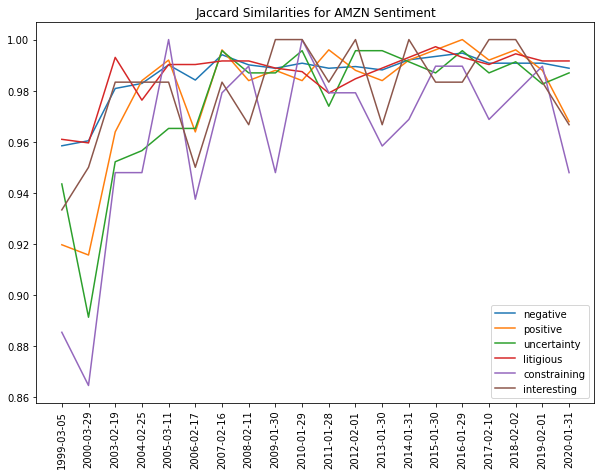

In [97]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment][::-1] for sentiment in sentiments],
    file_dates[example_ticker][1:][::-1],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

Let's leave it at that for now. What do you see in the final plot? Are there any patterns that can potentially be exploited? Think about a possible strategy you can implement. I will ask this for the prep poll.